# DOPP 2018W Exercise 2

Before we get started, please set the variables above to your student ID and name:

In [1]:
studentID = '11721356'
name = 'Santeri Friman'

This is the template for the second exercise in data oriented programming paradigms (2018W). 
Before you get started, please read the instructions in this notebook carefully.

### Preliminaries:
 - In order to get a valid score, you must rename this file from `exercise_2.ipynb` to `%s_exercise_2.ipynb % student_id`.

- Please use only Python version 3 (3.6+ recommended). It is recommended to install Anaconda or Miniconda. 

- Most of the code in this notebook will be scored using unit tests. 
- Please use the code stubs provided, do not rename any functions, and add and modify your code only at the provided markers. 
- Check and make sure that your submission executes without any errors before submitting it
- The submission will be executed on a Unix system (if you use Windows, please make sure that you use the functionality provided in the os module to make sure your path names work on Unix)
- For the submission, only this (renamed) notebook file needs to be uploaded to TUWEL. The data will be available on the same path in the directory we put your notebook for grading.


The submission deadline is **12.12.2018 23:55.**

In [10]:
# Note: The only imports allowed are those contained in Python's standard library, pandas, numpy, scipy and matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import datetime
#import sklearn...
import seaborn as sns
import sklearn as sklearn
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.preprocessing import scale, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR


In [11]:
import warnings
warnings.filterwarnings('ignore')

## Goal
In this exercise, you will 
 * use `pandas` to read, prepare and transform data,
 * use `matplotlib` to visually alayse data,
 * use `scikit-learn` to build prediction models.


The goal of this exercise is to model the relationship between weather observations and the prevalence of new influenza infections.

To investigate a potential relationship, we will use two datasets:
 * daily weather observation data in Vienna (2012-2018)
 * weekly reports on [new influenza infections](https://www.data.gv.at/katalog/dataset/grippemeldedienst-stadt-wien) in Vienna (2009-2018).

Note that the weather data set differs from the one used in exercise 1 and be sure to use the one provided for exercise 2. The data to be used can be found in the subdirectory named `data`. 
If you develop your submission on Windows, please make sure that you don't use any backslashes in the file names, because the submission won't run on Unix systems. 
Either use normal slashes, or use the functions provided in the `os.path` module. 
If you stick with the provided function templates, you should be fine.

To complete this exercise, you will have to:
* prepare the data, which (at a minimum) involves the following:
    - handling missing values,
    - handling outliers
    - temporal alignment (i.e. convert daily data to weekly data using appropriate aggregation functions),
* analyse the data:
    - compare descriptive statistics,
    - visually investigate the raw data to gain an understanding of the data, identify patterns, outliers etc.,
    - look at the relationship between the variables of interest,
* model the relationship:
    - fit a model that predicts new infections from weather observation data.

## Task 1: Load Data

### Weather observations <span style="color:blue">(1 P)</span>

As a first step, implement the method `load_weather_data()`, which should read all individual (yearly) data sets from the csv files in `data` into a single `pd.DataFrame` and return it. 

- add a column for the year
- add a `week` column containing the week number (use Pandas built-in datetime handling features to get the week number for each given date)
- create a `MultiIndex` from the date columns with the following hierarchy: `year` - `month` - `week` - `day` (make sure to label them accordingly)
- make sure that all columns are appropriately typed
- make sure that you load all the data (2012-2018)

**Hints:**
 - It is advisable not to append each data set individually, but to read each data frame, store it into a list and  combine them once at the end.
 - Your resulting data frame should look as follows:
 
![Weather data frame example](weather_dataFrame_example.png)

In [12]:
def load_weather_data():
    """ 
    Load all weather data files and combine them into a single Pandas DataFrame.
    Add a week column and a hierarchical index (year, month, week, day)
    
    Returns
    --------
    weather_data: data frame containing the weather data
    """
    # TODO: your changes here
    # load data

    path = r'data/weather'
    allFiles = glob.glob(path + '/*.csv')
    print(allFiles)
    weather_data = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        df = pd.read_csv(file_, index_col=0)
        list_.append(df)
    weather_data  = pd.concat(list_, axis=0, ignore_index=True)
    cols_to_move = ['year', 'month', 'day']
    weather_data = weather_data[[c for c in cols_to_move if c in weather_data] + [c for c in weather_data if c not in cols_to_move]]
    weather_data.insert(2, 'week', pd.to_datetime({'year': weather_data['year'], 'month': weather_data['month'], 'day': weather_data['day']}).apply(lambda x : x.isocalendar()[1]))
    
    # create MultiIndex
    index_cols = ['year', 'month', 'week', 'day']
    weather_data.set_index(index_cols, inplace=True)
    weather_data.sort_values(index_cols, ascending=[0,1,1,1], inplace=True)
    return weather_data 

data_weather = load_weather_data()

['data/weather/weather_2013.csv', 'data/weather/weather_2016.csv', 'data/weather/weather_2018.csv', 'data/weather/weather_2017.csv', 'data/weather/weather_2014.csv', 'data/weather/weather_2012.csv', 'data/weather/weather_2015.csv']


hum_14h  hum_19h  hum_7h  hum_dailyMean  precip  \
year month week day                                                    
2018 1     1    1       62.0     68.0    96.0             75     0.0   
                2       60.0     74.0    68.0             67     0.3   
                3       88.0     69.0    78.0             78     3.4   
                4       56.0     70.0    62.0             63     6.4   
                5       65.0     83.0    74.0             74     6.4   
                6       90.0     94.0    97.0             94     0.0   
                7       85.0     86.0    91.0             87     1.2   
           2    8       98.0     98.0    98.0             98     1.7   
                9       86.0     84.0    95.0             88     4.6   
                10      96.0     96.0    96.0             96     7.6   
                11      78.0     82.0    98.0             86     0.0   
                12      83.0     89.0    82.0             85     2.1   
                13      96.0     96.0    90.0             94     1.6   
                14      89.0     90.0    94.0             91     2.2   
           3    15      77.0     80.0    88.0             82     0.0   
                16      91.0     94.0    91.0             92     1.8   
                17      71.0     63.0    80.0             71     0.5   
                18      65.0     68.0    70.0             68     1.3   
                19      61.0     72.0    82.0             72     6.2   
                20      65.0     83.0    92.0             80     1.6   
                21      89.0     75.0    90.0             85     0.6   
           4    22      73.0     82.0    82.0             79     1.4   
                23      79.0     80.0    83.0             81     1.4   
                24      85.0     92.0    85.0             87     1.4   
                25      74.0     81.0    90.0             82     0.0   
                26      84.0     90.0    95.0             90     0.0   
                27      78.0     78.0    89.0             82     0.0   
                28      52.0     76.0    92.0             73     0.0   
           5    29      52.0     57.0    67.0             59     0.0   
                30      54.0     73.0    73.0             67     1.1   
...                      ...      ...     ...            ...     ...   
2012 12    48   1       65.0     70.0    76.0             70     0.0   
                2       59.0     85.0    80.0             75     0.1   
           49   3       58.0     75.0    81.0             71     0.3   
                4       98.0     82.0    84.0             88     2.2   
                5       71.0     97.0    77.0             82     2.9   
                6       69.0     70.0    97.0             79     1.3   
                7       65.0     88.0    83.0             79     0.0   
                8       67.0     65.0    83.0             72     0.0   
                9       58.0     58.0    72.0             63     1.1   
           50   10      72.0     76.0    89.0             79     1.1   
                11      86.0     74.0    95.0             85     0.9   
                12      61.0     64.0    69.0             65     0.0   
                13      68.0     82.0    89.0             80     0.0   
                14      82.0     93.0    85.0             87     0.0   
                15      97.0    100.0    98.0             98     5.9   
                16      95.0     97.0    99.0             97     0.4   
           51   17     100.0    100.0    99.0            100     0.1   
                18      95.0     98.0    97.0             97     1.5   
                19      88.0     87.0    89.0             88     0.7   
                20      66.0     90.0    80.0             79     0.3   
                21      96.0     94.0    94.0             95     0.8   
                22      88.0     92.0    96.0             92     0.4   
                23      98.0     99.0    97.0             98 

In [13]:
print("data_weather.info(): ")
data_weather.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2435 entries, (2018, 1, 1, 1) to (2012, 12, 52, 30)
Data columns (total 18 columns):
hum_14h           2315 non-null float64
hum_19h           2315 non-null float64
hum_7h            2315 non-null float64
hum_dailyMean     2435 non-null int64
precip            2435 non-null float64
skyCover_14h      2431 non-null float64
skyCover_19h      2431 non-null float64
skyCover_7h       2431 non-null float64
sun_hours         2431 non-null float64
temp_14h          2315 non-null float64
temp_19h          2315 non-null float64
temp_7h           2315 non-null float64
temp_dailyMax     2435 non-null float64
temp_dailyMean    2435 non-null float64
temp_dailyMin     2435 non-null float64
temp_minGround    2435 non-null float64
wind_degrees      2342 non-null float64
wind_mSec         2428 non-null float64
dtypes: float64(17), int64(1)
memory usage: 353.0 KB


In [14]:
print("\n")
print("data_weather.describe()")
data_weather.describe()

,hum_14h,hum_19h,hum_7h,hum_dailyMean,precip,skyCover_14h,skyCover_19h,skyCover_7h,sun_hours,temp_14h,temp_19h,temp_7h,temp_dailyMax,temp_dailyMean,temp_dailyMin,temp_minGround,wind_degrees,wind_mSec
count,2315.000000,2315.000000,2315.000000,2435.000000,2435.000000,2431.000000,2431.000000,2431.000000,2431.000000,2315.000000,2315.000000,2315.000000,2435.000000,2435.000000,2435.000000,2435.000000,2342.000000,2428.000000
mean,60.366739,69.112743,79.861339,69.220534,2.382752,6.802962,6.407240,6.626491,5.804360,16.597408,14.003067,11.221771,16.390144,12.279179,8.126160,6.031499,232.075448,11.925453
std,18.698925,17.634060,12.581223,14.663811,5.471089,3.167649,3.478141,3.530866,4.782965,14.240920,12.947291,11.676265,9.809922,8.408058,7.292182,7.042154,92.020922,4.414138
min,18.000000,22.000000,41.000000,34.000000,-0.100000,0.000000,0.000000,0.000000,0.000000,-40.000000,-40.000000,-40.000000,-8.300000,-11.500000,-15.000000,-17.800000,1.000000,2.900000
25%,45.000000,54.000000,70.000000,57.000000,0.000000,4.000000,3.000000,3.000000,0.850000,7.500000,5.500000,3.800000,8.500000,5.500000,2.500000,0.700000,151.000000,8.700000
50%,58.000000,70.000000,80.000000,69.000000,0.100000,8.000000,8.000000,8.000000,5.400000,15.700000,12.900000,10.400000,16.700000,12.500000,8.400000,6.100000,275.000000,11.500000
75%,74.000000,84.000000,91.000000,80.000000,2.000000,9.000000,9.000000,10.000000,10.000000,23.700000,20.400000,17.150000,24.450000,19.100000,14.000000,11.700000,298.000000,14.700000
max,100.000000,100.000000,100.000000,100.000000,62.200000,10.000000,10.000000,10.000000,15.300000,131.200000,110.800000,99.200000,38.500000,30.100000,25.300000,23.300000,360.000000,32.700000


### Influenza infections <span style="color:blue">(1 P)</span>

Load and prepare the second data set, which contains the number of new influenza infections on a weekly basis, as follows:

- get rid of all columns except `Neuerkrankungen pro Woche`, `Jahr`, and `Kalenderwoche`
- rename `Neuerkrankungen pro Woche` to `weekly_infections`
- create a `MultiIndex` from the `Jahr` (→ `year`) and `Kalenderwoche` (→ `week`) columns
- make sure that all columns are appropriately typed
- your resulting data frame should look as follows:


![Example data frame](influenza_dataFrame_example.png)

In [15]:
def load_influenza_data():
    """ 
    Load and prepare the influenza data file
    
    Returns
    --------
    influenza_data: data frame containing the influenza data
    """
    # TODO: your changes here
    influenza_data = pd.read_csv('data/influenza/influenza.csv')
    influenza_data.drop(influenza_data.columns[[0,1,2,6]], axis=1, inplace=True)
    # transform column 'Kalendarwoche' from '40. Woche' -> '40' and rename it 'week' (use apply)
    influenza_data['Kalenderwoche'] = influenza_data['Kalenderwoche'].apply(lambda x : int(x.split('.')[0]))
    influenza_data.columns = ['year', 'week', 'weekly_infections']
    influenza_data.set_index(['year', 'week'], inplace=True)
    influenza_data.sort_values(['year', 'week'], ascending=True, inplace=True)

    # set year and week as index
    return influenza_data

data_influenza = load_influenza_data()

In [16]:
print("\n")
print("data_influenza.describe()")
data_influenza.describe()

,weekly_infections
count,233
unique,100
top,6900
freq,10


## Task 2: Handling Missing values <span style="color:blue">(4 P)</span>

If you take a closer look at the data, you will notice that a few of the observations are missing.

There are a wide range of standard strategies to deal with such missing values, including:

- row deletion
- substitution methods (e.g., replace with mean or median)
- hot-/cold-deck methods (impute from a randomly selected similar record)
- regression methods

To decide which strategy is appropriate, it is important to investigate the mechanism that led to the missing values to find out whether the missing data is missing completely at random (MCAR), missing at random (MAR), or missing not at random (MNAR). 

 - **MCAR** means that there is no relationship between the missingness of the data and any of the values.
 - **MAR** means that that there is a systematic relationship between the propensity of missing values and the observed data, but not the missing data.
 - **MNAR** means that there is a systematic relationship between the propensity of a value to be missing and its values. 

To find out more about what mechanisms may have caused the missing values, you talked to the metereologist that compiled the data. 
She told you that she does not know why some of the temperature readings are missing, but that it may be that someone forgot to record them. In any case, it is likely that the propensity of a temperature value to be missing does not have anything to do with the weather itself.

As far as the missing humidity readings are concerned, she says that according to her experience, she suspects that the humidity sensor is less reliable in hot weather.

The missing wind speed and direction sensor readings were due to a hardware defect.

Check the plausibility of these hypotheses in the data, consider the implications, and devise an appropriate strategy to deal with the various missing values.

To implement your strategy, you can use a range of standard mechanisms provided by Pandas or implement a custom strategy (for extra points):

**Chocolate challenge:**
More advanced strategies (e.g., building a machine learning model that predicts MAR data based on other observed values) may give you better results if the propensity of data to be missing is of a systematic nature. If you want to participate in the chocolate challenge for the best approximation of missing values, you can implement your missing value prediction model in `handleMissingValuesAdvanced` below. 

In [17]:
def handle_missingValues_simple(incomplete_data):
    """ 
    Parameters
    --------
    incomplete_data: data frame containing missing values 
    
    Returns
    --------
    complete_data: data frame not containing any missing values
    """
    # TODO: your changes here
    complete_data = incomplete_data.fillna(0)
    # MCAR: assuming that temperature missing is completely random, no correlation with weather itself (somebody forgot)
    # MNAR: Humidty missing relates to having high temperatures, can be deleted
    # MAR: Missing wind speeds is due to hardware defect
    
    """
    MISSING VALUES BY COLUMN:
    hum_14h           120
    hum_19h           120
    hum_7h            120
    hum_dailyMean       0
    precip              0
    skyCover_14h        4
    skyCover_19h        4
    skyCover_7h         4
    sun_hours           4
    temp_14h          120
    temp_19h          120
    temp_7h           120
    temp_dailyMax       0
    temp_dailyMean      0
    temp_dailyMin       0
    temp_minGround      0
    wind_degrees       93
    wind_mSec           7

    """    
    
    def getTemperatureRanges():
        tempRanges = []
        intervalForRanges = (incomplete_data['temp_dailyMax'].max() + abs(incomplete_data['temp_dailyMax'].min())) / 5

        min_temp = incomplete_data['temp_dailyMax'].min()

        for i in range(5):    
            tempRanges.append((min_temp, min_temp+intervalForRanges))
            min_temp += intervalForRanges    

        return tempRanges
    
    # this is to display missing values in different temperature ranges
    tempRanges = getTemperatureRanges()
    
    def countMissingHumidityValuesInRange(min_temp, max_temp):
        rows_under_temp = incomplete_data[(incomplete_data['temp_dailyMax']>min_temp) & (incomplete_data['temp_dailyMax']<max_temp)]
        return rows_under_temp[rows_under_temp['hum_14h'].isnull()].shape[0]
        
    df = pd.DataFrame()
    
    for i in range(len(tempRanges)):
        mintemp = tempRanges[i][0] 
        maxtemp = tempRanges[i][1]
        
        df[str(round(mintemp, 2)) + "-" + str(round(maxtemp,2))] = [countMissingHumidityValuesInRange(mintemp, maxtemp)]
        df = df.iloc[0:1]
        
    #yvalues = df.iloc[0].values
    #xvalues = np.array([tempRanges[0][0], tempRanges[1][0], tempRanges[2][0],tempRanges[3][0],tempRanges[4][0]])

    #plt.bar(xvalues, yvalues, align='center', width=5, tick_label=df.columns.values)
    #plt.xlabel("Temperature Ranges")
    #plt.ylabel("Missing Humidity Values")
    
    # From the barchart we can see that missing humidity values only appear in the higher temperatures    
    # BASED ON THE DATA ANALYSIS AND STATEMENT MISSING HUMIDITY VALUES CLASSIFIES AS MNAR 
    
    incomplete_data['hum_14h'].fillna(method="pad", inplace=True)
    incomplete_data['hum_19h'].fillna(method="pad", inplace=True)
    incomplete_data['hum_7h'].fillna(method="pad", inplace=True)
    
    # incomplete_data[incomplete_data['temp_dailyMean'].isnull()].shape 
    # (0, 18) WE CAN SEE THAT DAILYMEAN IS NEVER MISSING
    # MISSING TEMPERATURE VALUES ARE MCAR BECAUSE PEOPLE ARE FORGOTTING TO INPUT THEM
    # we can use daily mean as the value to put into missing measurements because dailymeans are not missing
    incomplete_data['temp_14h'].fillna(value=incomplete_data['temp_dailyMean'], inplace=True)
    incomplete_data['temp_19h'].fillna(value=incomplete_data['temp_dailyMean'], inplace=True)
    incomplete_data['temp_7h'].fillna(value=incomplete_data['temp_dailyMean'], inplace=True)    
    
    # MISSING SPEED/DIR are HW Defects which are MAR
    # THESE can be filled with the mean value of each days wind 

    incomplete_data['wind_degrees'].fillna(incomplete_data['wind_degrees'].mean(), inplace=True)
    incomplete_data['wind_mSec'].fillna(incomplete_data['wind_mSec'].mean(), inplace=True)
    
    # sun hours can be taken from previous years value of the same date
    # but to save time we just drop the values because they are only 4 rows, same goes for cloud data
    incomplete_data.dropna(inplace=True)
    incomplete_data.dropna(inplace=True)
    incomplete_data.dropna(inplace=True)
    incomplete_data.dropna(inplace=True)
    
    # check that each row is empty
    # print(incomplete_data.isnull().sum())
    return complete_data


def handle_missingValues_advanced (incomplete_data):
    """ 
    Parameters
    --------
    data: data frame containing missing values 
    
    Returns
    --------
    data: data frame not containing any missing values
    """
    # TODO: your changes here
    
    return complete_data
    
data_weather_complete = handle_missingValues_simple(data_weather)

###  Discussion

#### Pros and Cons of strategies for dealing with missing data <span style="color:blue">(1 P)</span>

In the cell provided below, discuss the PROs and CONs of various strategies (row deletion, imputation, hot deck methods etc.) for dealing with missing data. Discuss when it is appropriate to use each method.

[T2_Pros_and_Cons]

Row deletion brings easy results but it can affect the the results heavily, especially if many rows gets removed. it can be used when there's few rows that have missing data

Imputation and it's different methods can be very powerful tools. It can provide very good results if data and relationships for missing values are known. However, for example imputing the data by the mean of the data set can sometimes hugely unbalance the dataset and it doesn't take into considerations other values that might affect that particular cell to be imputed. Imputing by mean is good when the variance is low, imputing by 0 is good when the data is small in number and 0 doesnt affect the other parts.

hot-cold-deck methods are good also when standard deviation and also when the data in the set are seemingly random. Also can be very dangerous if for example imputing missing temperature data with this tactic and when the random data could be a temperature measurement from winter even if the date itself is in the summer


[/T2_Pros_and_Cons]

#### Your chosen strategy <span style="color:blue">(1 P)</span>

Explain your chosen strategy for dealing with missing values for the various attributes in the cell below.


[T2_MissingValueStrategy]

Missing Humidity Values:
Used the pad method to take the previous humidity value because of the assumption that humidity does not necessarily change too rapidly and a previous measurement data could be closer

Missing Temperature Values:
take the dailyMean value. I think this is self-explanatory

Missing wind values:
Imputing with mean strategy because it provides a nice little center point.

Other missing values:
These could be dropped because of small number of rows. If these rows would have been significant, a good strategy would have been to choose the data from similar date from previous years. (hot-cold-deck)

[/T2_MissingValueStrategy]

## Task 3: Handling Outliers <span style="color:blue">(2 P)</span>

If you take a closer look at some of the observations, you should notice that some of the temperature values are not particularly plausible (hint: plotting histograms of the distributions helps). Hypothesize on the nature of these outliers and implement a strategy to handle them.

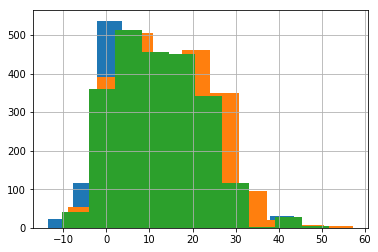

In [18]:
def handle_outliers(noisy_data):
    """ 
    Parameters
    --------
    noisy_data: data frame that contains outliers
    
    Returns
    --------
    cleaned_data: data frame with outliers
    """
    # TODO: your changes here
    cleaned_data = noisy_data
    """
    hum_14h           2435 non-null float64
    hum_19h           2435 non-null float64
    hum_7h            2435 non-null float64
    hum_dailyMean     2435 non-null int64
    precip            2435 non-null float64
    skyCover_14h      2435 non-null float64
    skyCover_19h      2435 non-null float64
    skyCover_7h       2435 non-null float64
    sun_hours         2435 non-null float64
    temp_14h          2435 non-null float64
    temp_19h          2435 non-null float64
    temp_7h           2435 non-null float64
    temp_dailyMax     2435 non-null float64
    temp_dailyMean    2435 non-null float64
    temp_dailyMin     2435 non-null float64
    temp_minGround    2435 non-null float64
    wind_degrees      2435 non-null float64
    wind_mSec         2435 non-null float64
    dtypes: float64(17), int64(1)
    memory usage: 353.0 KB
    """
    # temperature measurements seems to be following normal distribution so we can 
    # keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.

    
    cleaned_data = cleaned_data[np.abs(cleaned_data.temp_7h-cleaned_data.temp_7h.mean()) <= (3*cleaned_data.temp_7h.std())]
    cleaned_data = cleaned_data[np.abs(cleaned_data.temp_14h-cleaned_data.temp_14h.mean()) <= (3*cleaned_data.temp_14h.std())]
    cleaned_data = cleaned_data[np.abs(cleaned_data.temp_19h-cleaned_data.temp_14h.mean()) <= (3*cleaned_data.temp_19h.std())]
    
    #cleaned_data.temp_7h.hist()
    #cleaned_data.temp_14h.hist()
    #cleaned_data.temp_19h.hist()

    return cleaned_data
    
data_weather_cleaned = handle_outliers(data_weather_complete)

#### Your chosen strategy <span style="color:blue">(1 P)</span>

Explain your chosen strategy for dealing with outliers in the cell below.


[T3_OutlierStrategy]

Since the temperature data was following normal distribution, it was safe to drop all rows where the temperature measurements where +/- 3 standard deviations from the mean.

[/T3_OutlierStrategy]

## Task 4: Aggregate values <span style="color:blue">(1 P)</span>

Aggregate the observations on a weekly basis. Return a data frame with a hierarchical index (levels `year` and `week`) on the vertical axis and the following weekly aggregations as columns:

- `temp_weeklyMin`: minimum of `temp_dailyMin`
- `temp_weeklyMax`: mean of `temp_dailyMax`
- `temp_weeklyMean`: mean of `temp_dailyMean`
- `temp_7h_weeklyMedian`: median of `temp_7h`
- `temp_14h_weeklyMedian`: median of `temp_14h`
- `temp_19h_weeklyMedian`: median of `temp_19h`

- `hum_weeklyMean`: mean of `hum_dailyMean`
- `hum_7h_weeklyMedian`: median of `hum_7h`
- `hum_14h_weeklyMedian`: median of `hum_14h`
- `hum_19h_weeklyMedian`: median of `hum_19h`

- `precip_weeklyMean`: mean of `precip`
- `wind_mSec_mean`: mean of `wind_mSec`

In [21]:
def aggregate_weekly(data):
    """ 
    Parameters
    --------
    data: weather data frame
    
    Returns
    --------
    weekly_stats: data frame that contains statistics aggregated on a weekly basis
    """
    # TODO: your changes here
    
    """
    - `temp_weeklyMin`: minimum of `temp_dailyMin`
    - `temp_weeklyMax`: mean of `temp_dailyMax`
    - `temp_weeklyMean`: mean of `temp_dailyMean`
    - `temp_7h_weeklyMedian`: median of `temp_7h`
    - `temp_14h_weeklyMedian`: median of `temp_14h`
    - `temp_19h_weeklyMedian`: median of `temp_19h`

    - `hum_weeklyMean`: mean of `hum_dailyMean`
    - `hum_7h_weeklyMedian`: median of `hum_7h`
    - `hum_14h_weeklyMedian`: median of `hum_14h`
    - `hum_19h_weeklyMedian`: median of `hum_19h`

    - `precip_weeklyMean`: mean of `precip`
    - `wind_mSec_mean`: mean of `wind_mSec`
    """
    weekly_weather_data = pd.DataFrame()    
    weekly_weather_data['temp_weeklyMin'] = data['temp_dailyMin'].groupby(['year', 'week']).min()
    weekly_weather_data['temp_weeklyMax'] = data['temp_dailyMax'].groupby(['year', 'week']).mean()
    weekly_weather_data['temp_weeklyMean'] = data['temp_dailyMean'].groupby(['year', 'week']).mean()
    weekly_weather_data['temp_7h_weeklyMedian'] = data['temp_7h'].groupby(['year', 'week']).median()
    weekly_weather_data['temp_14h_weeklyMedian'] = data['temp_14h'].groupby(['year', 'week']).median()
    weekly_weather_data['temp_19h_weeklyMedian'] = data['temp_19h'].groupby(['year', 'week']).median()
    weekly_weather_data['hum_weeklyMean'] = data['hum_dailyMean'].groupby(['year', 'week']).mean()
    weekly_weather_data['hum_7h_weeklyMedian'] = data['hum_7h'].groupby(['year', 'week']).median()
    weekly_weather_data['hum_14h_weeklyMedian'] = data['hum_14h'].groupby(['year', 'week']).median()
    weekly_weather_data['hum_19h_weeklyMedian'] = data['hum_19h'].groupby(['year', 'week']).median()
    
    weekly_weather_data['precip_weeklyMean'] = data['precip'].groupby(['year', 'week']).mean()
    weekly_weather_data['wind_mSec_mean'] = data['wind_mSec'].groupby(['year', 'week']).mean()

    
    return weekly_weather_data

data_weather_weekly = aggregate_weekly(data_weather_cleaned)

## Task 5: Merge influenza and weather datasets <span style="color:blue">(1 P)</span>

Merge the `data_weather_weekly` and `data_influenza` datasets.

In [22]:
def merge_data(weather_df, influenza_df):
    """ 
    Parameters
    --------
    weather_df: weekly weather data frame
    influenza_df: influenza data frame
    
    Returns
    --------
    merged_data: merged data frame that contains both weekly weather observations and prevalence of influence infections
    """
    # TODO: your changes here
    merged_data = pd.DataFrame()    
    merged_data = pd.merge(weather_df, influenza_df, on=['year','week'], how='outer')
    merged_data = merged_data[merged_data['weekly_infections'].notnull()]
    merged_data.dropna(inplace=True)
    return merged_data

data_merged = merge_data(data_weather_weekly, data_influenza)

## Task 6: Visualization <span style="color:blue">(4 P)</span>

To get a better understanding of the dataset, create visualizations of the merged data set that help to explore the potential relationships between the variables before starting to develop a model.


**Note:** To hand in multiple figures, change the code accordingly (additional files should be named `%s_%u.png" % student_id, fileCount`).

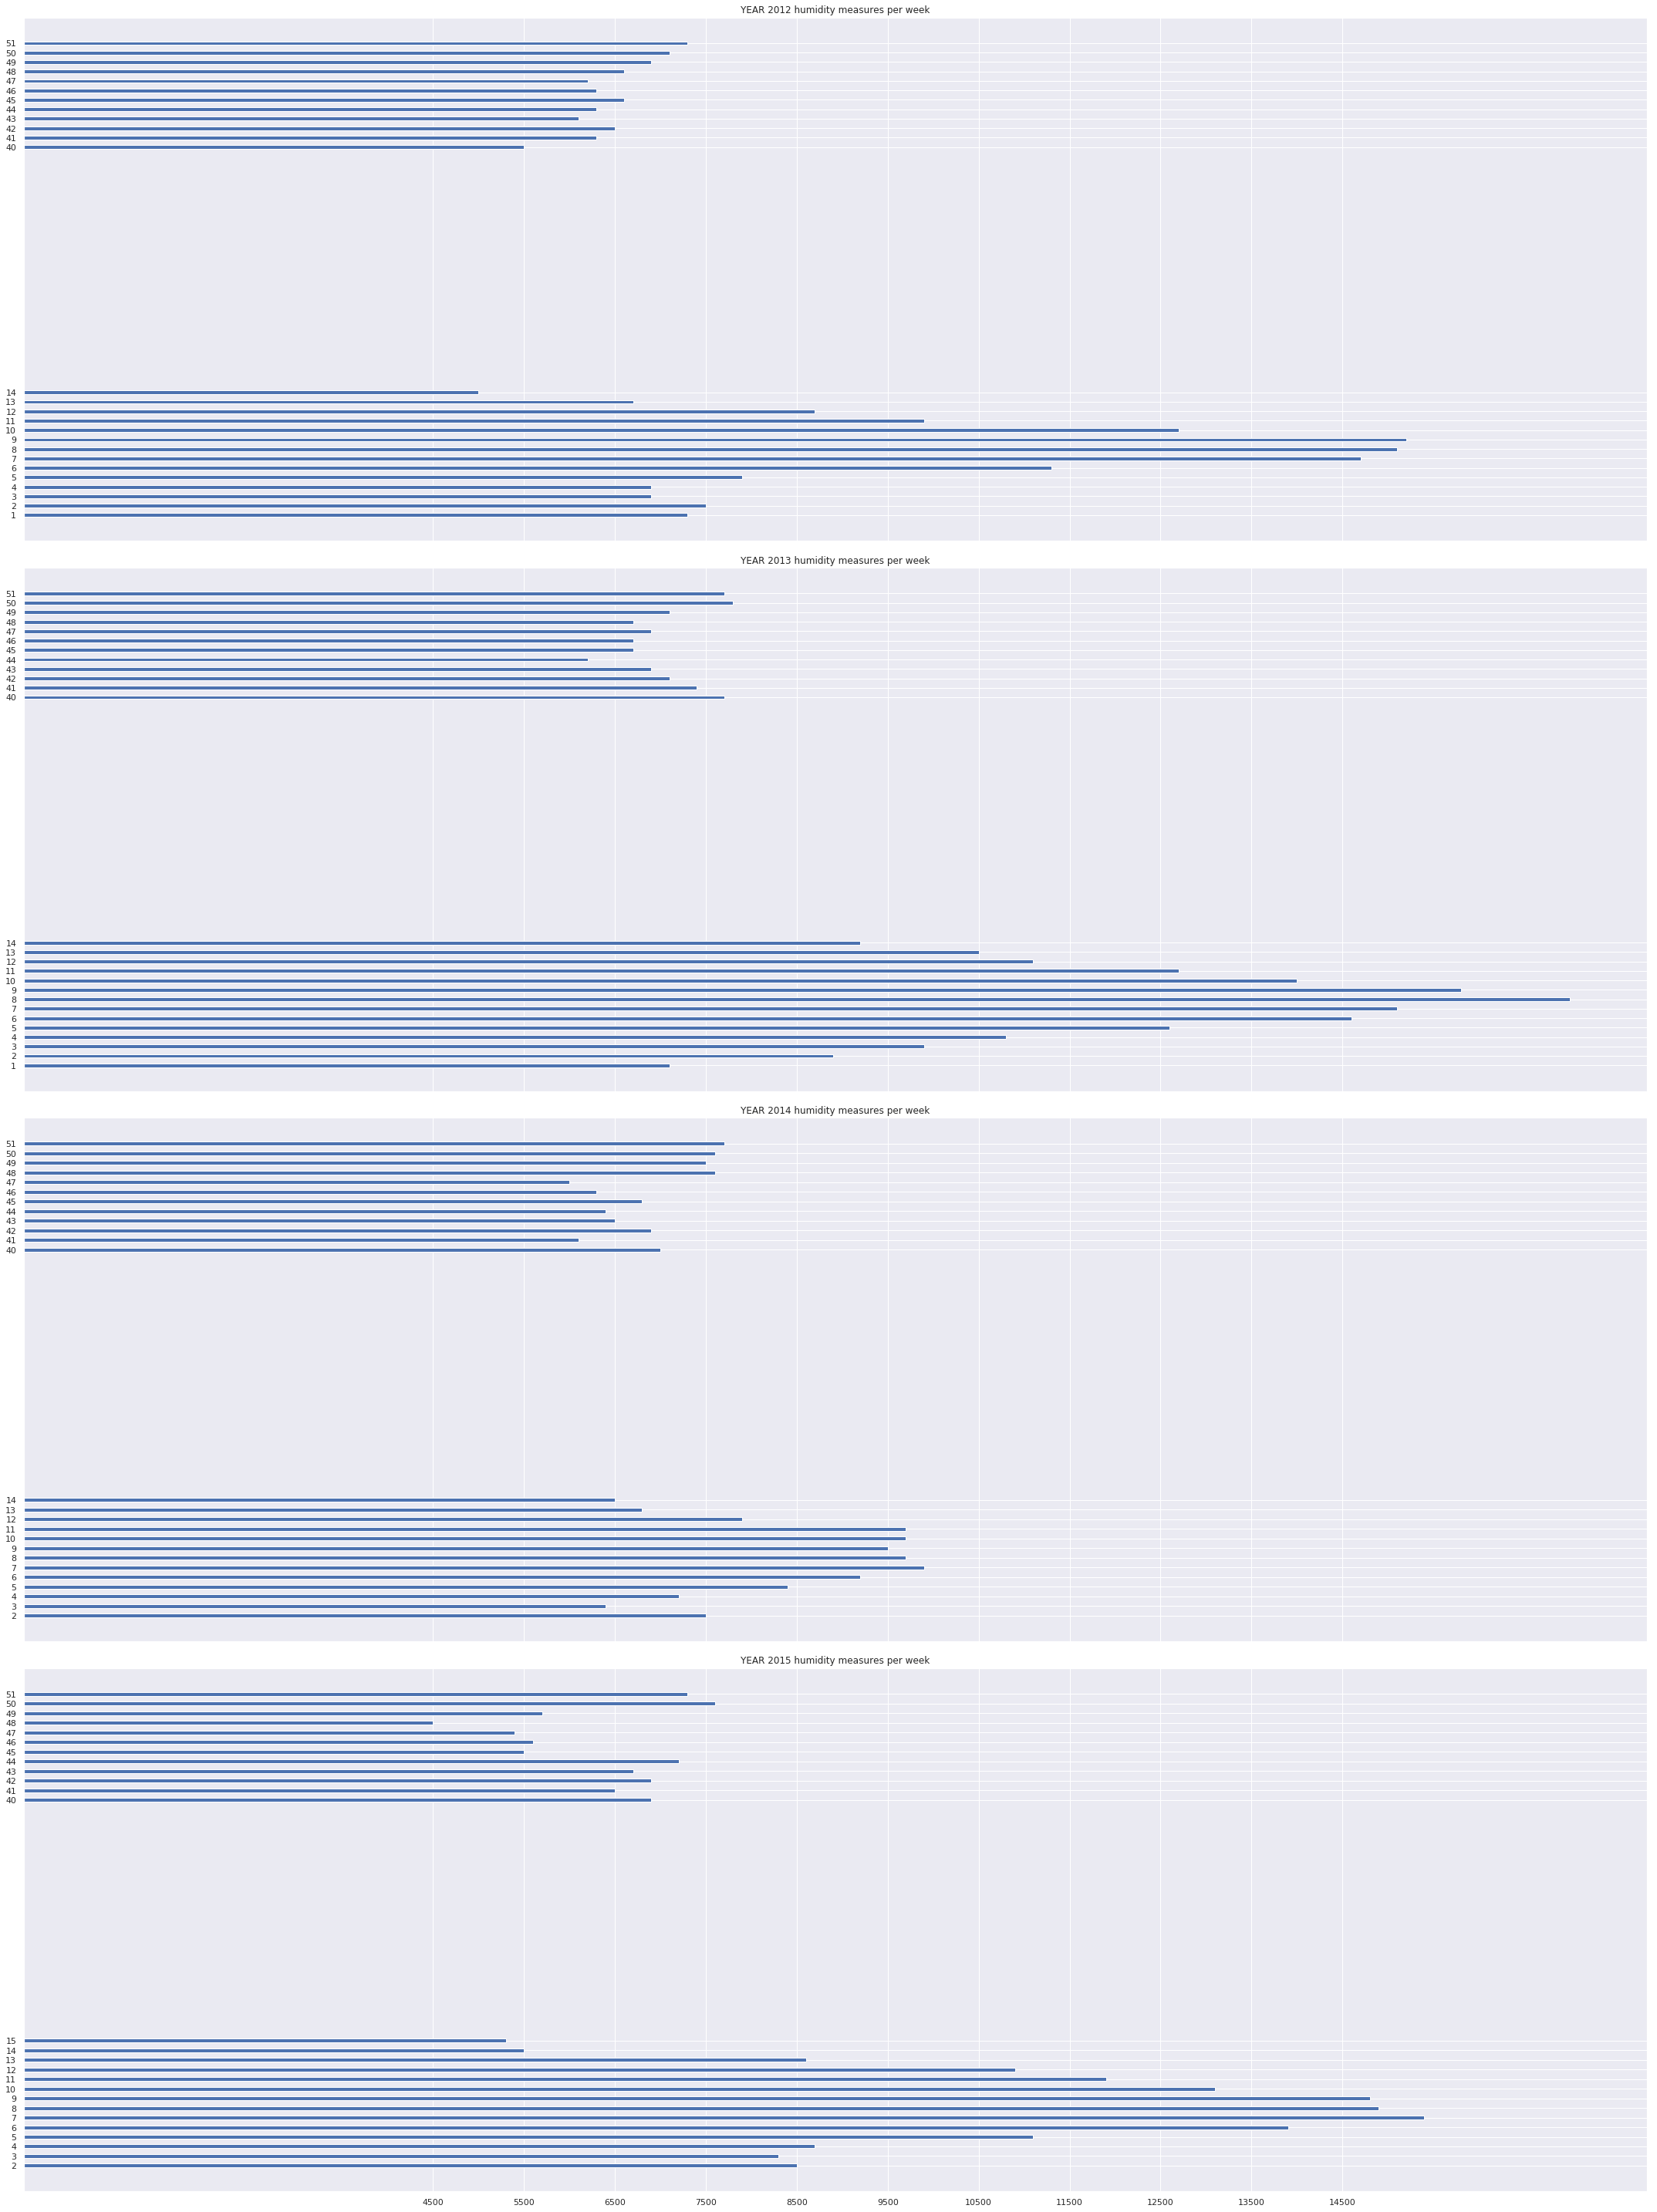

In [93]:
years = list(range(data_merged.index.values[0][0],data_merged.index.values[-1][0]+1))
annual_data = []
for year in years:
    year_data = data_merged.loc[year]
    weeks = year_data.index.values
    infections = year_data['weekly_infections']
    annual_data.append({'weeks': weeks, 'infections': infections.values.astype(int)})

f, axarr = plt.subplots(4, sharex=True,figsize=(30,40))

axarr[0].barh(annual_data[0]['weeks'], annual_data[0]['infections'], 0.4)
axarr[0].set_yticks(annual_data[0]['weeks'])
axarr[0].set_yticklabels(annual_data[0]['weeks'])
axarr[0].set_xticks(np.arange(min(annual_data[0]['infections']), max(annual_data[0]['infections'])+1, 1000))
axarr[0].set_title('YEAR 2012 humidity measures per week')

axarr[1].barh(annual_data[1]['weeks'], annual_data[1]['infections'], 0.4)
axarr[1].set_yticks(annual_data[1]['weeks'])
axarr[1].set_yticklabels(annual_data[1]['weeks'])
axarr[1].set_xticks(np.arange(min(annual_data[1]['infections']), max(annual_data[1]['infections'])+1, 1000))
axarr[1].set_title('YEAR 2013 humidity measures per week')

axarr[2].barh(annual_data[2]['weeks'], annual_data[2]['infections'], 0.4)
axarr[2].set_yticks(annual_data[2]['weeks'])
axarr[2].set_yticklabels(annual_data[2]['weeks'])
axarr[2].set_xticks(np.arange(min(annual_data[2]['infections']), max(annual_data[2]['infections'])+1, 1000))
axarr[2].set_title('YEAR 2014 humidity measures per week')

axarr[3].barh(annual_data[3]['weeks'], annual_data[3]['infections'], 0.4)
axarr[3].set_yticks(annual_data[3]['weeks'])
axarr[3].set_yticklabels(annual_data[3]['weeks'])
axarr[3].set_xticks(np.arange(min(annual_data[3]['infections']), max(annual_data[3]['infections'])+1, 1000))
axarr[3].set_title('YEAR 2015 humidity measures per week')


plt.tight_layout()
plt.show()
f.savefig(studentID+'_01.png', bbox_inches='tight')

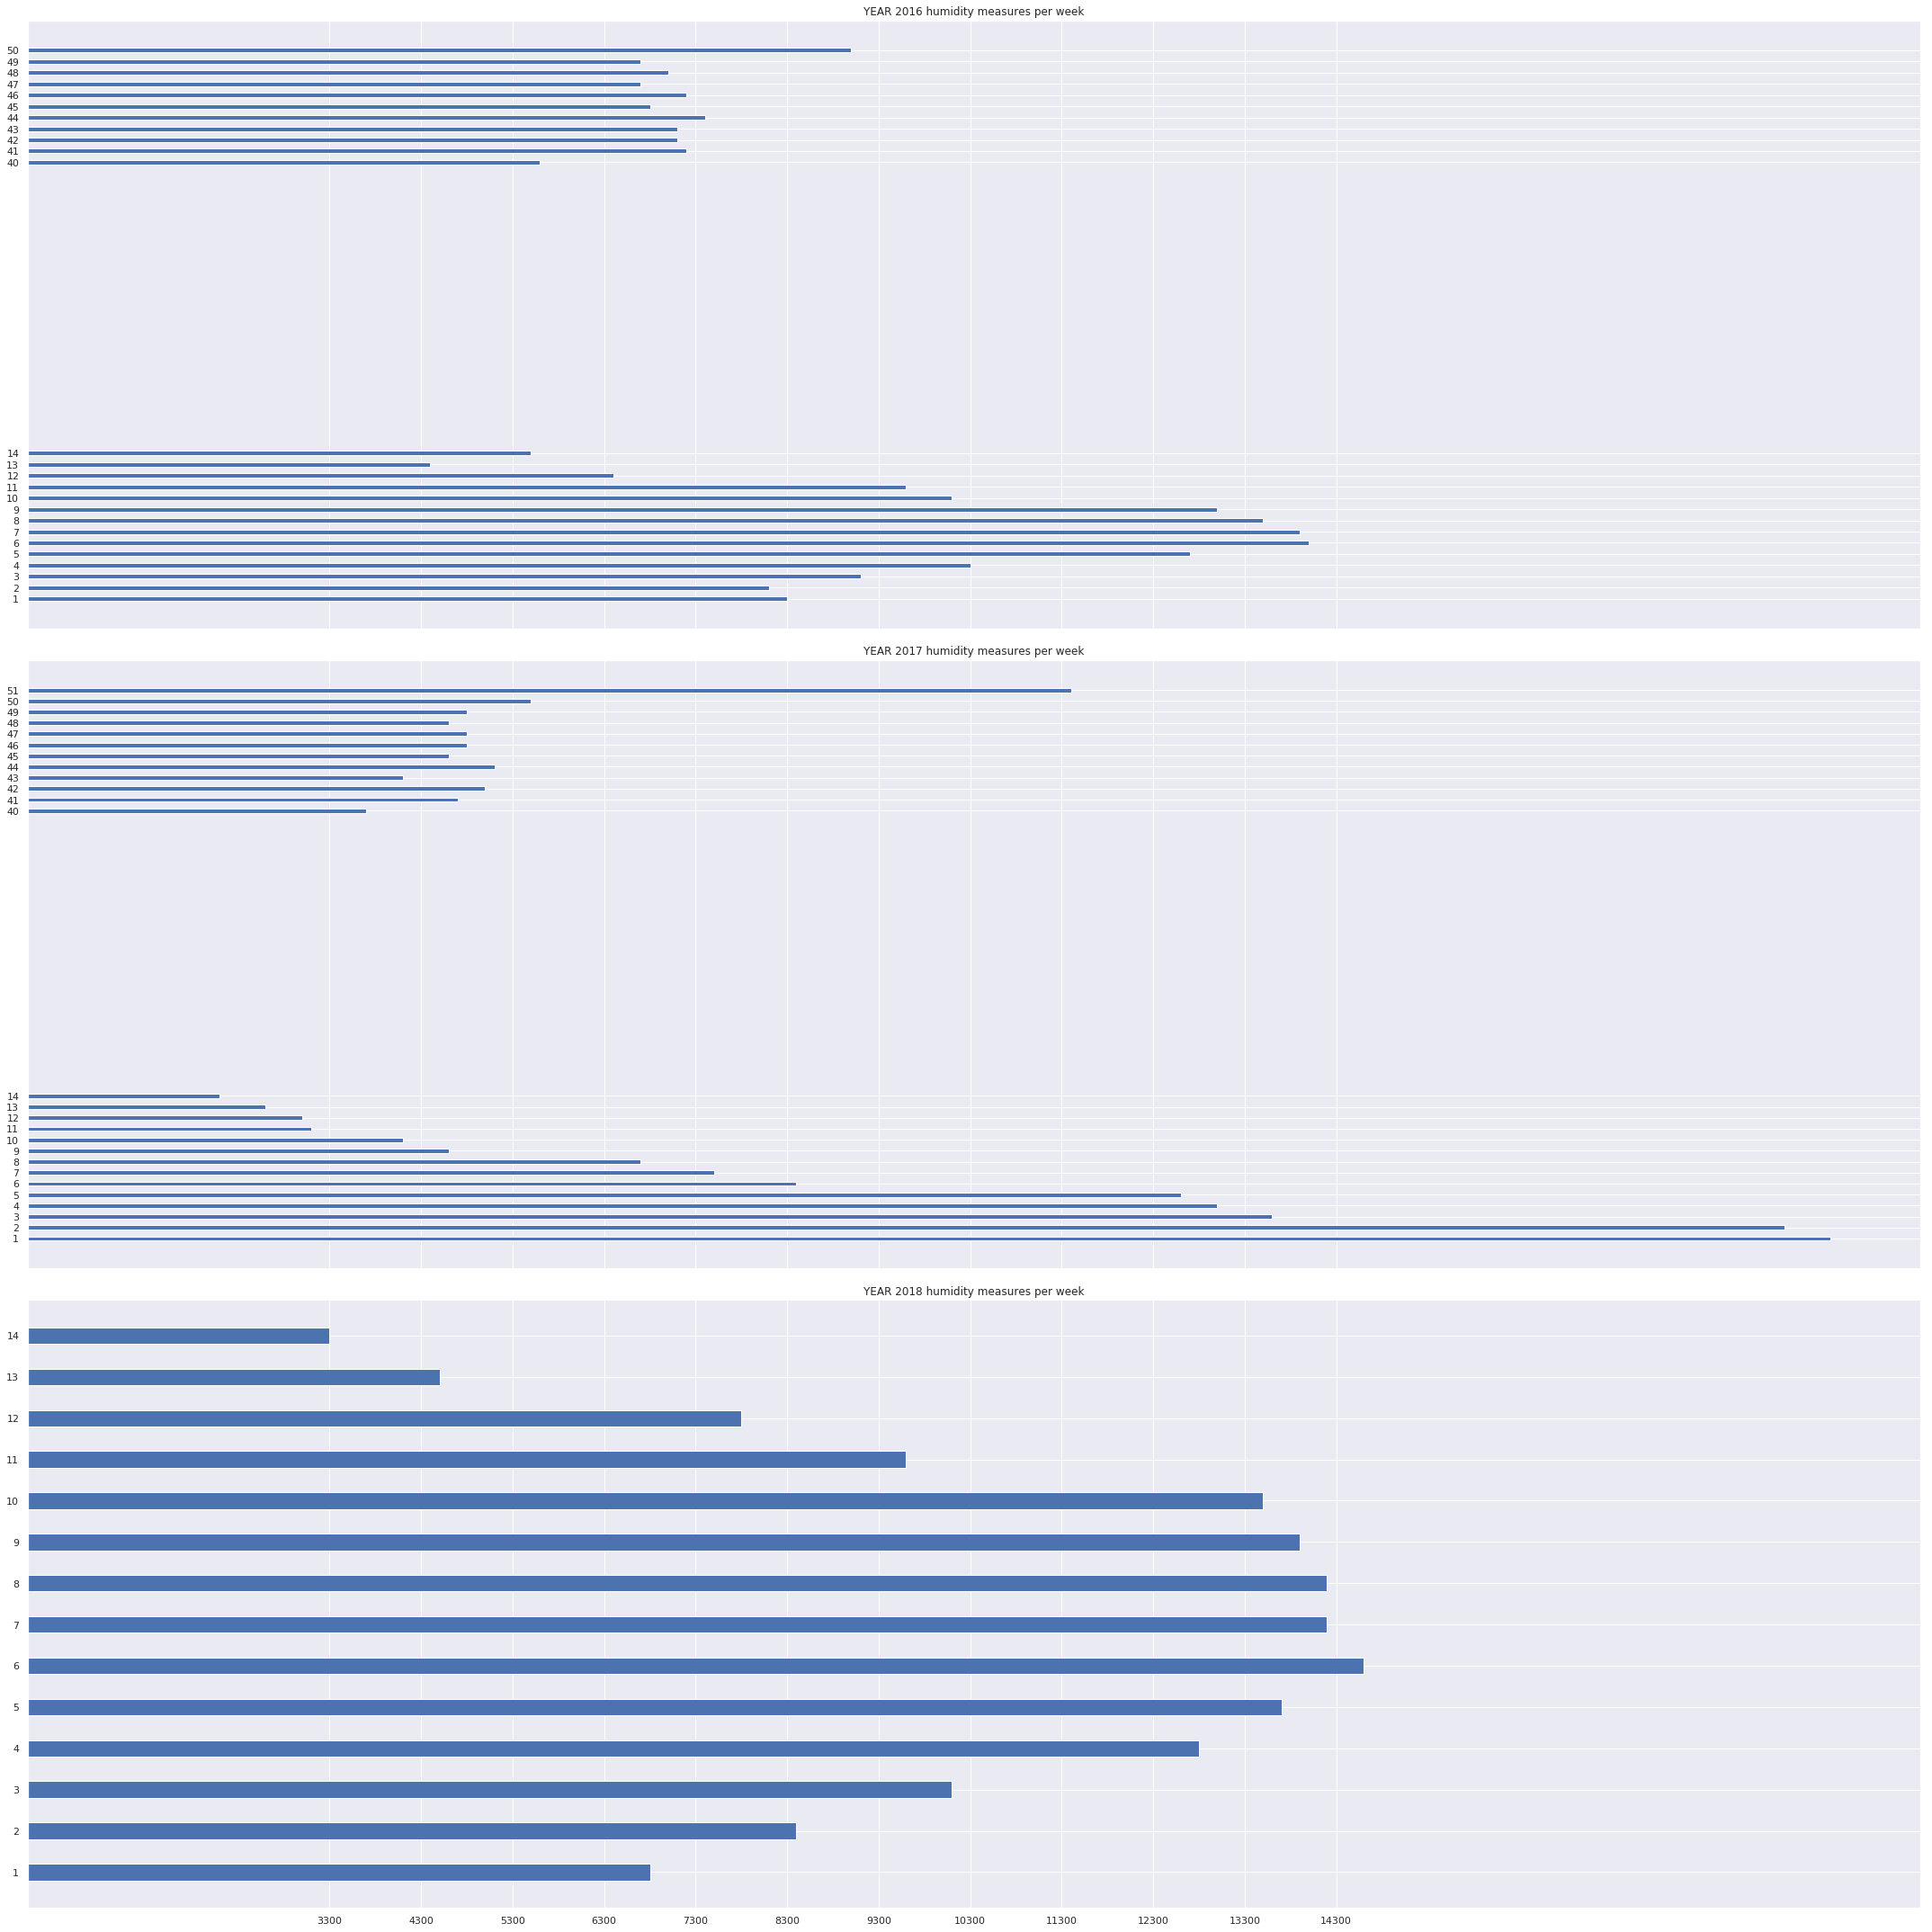

In [94]:
f, axarr = plt.subplots(3, sharex=True,figsize=(30,30))

axarr[0].barh(annual_data[4]['weeks'], annual_data[4]['infections'], 0.4)
axarr[0].set_yticks(annual_data[4]['weeks'])
axarr[0].set_yticklabels(annual_data[4]['weeks'])
axarr[0].set_xticks(np.arange(min(annual_data[4]['infections']), max(annual_data[4]['infections'])+1, 1000))
axarr[0].set_title('YEAR 2016 humidity measures per week')

axarr[1].barh(annual_data[5]['weeks'], annual_data[5]['infections'], 0.4)
axarr[1].set_yticks(annual_data[5]['weeks'])
axarr[1].set_yticklabels(annual_data[5]['weeks'])
axarr[1].set_xticks(np.arange(min(annual_data[5]['infections']), max(annual_data[5]['infections'])+1, 1000))
axarr[1].set_title('YEAR 2017 humidity measures per week')

axarr[2].barh(annual_data[6]['weeks'], annual_data[6]['infections'].astype(int), 0.4)
axarr[2].set_yticks(annual_data[6]['weeks'])
axarr[2].set_yticklabels(annual_data[6]['weeks'])
axarr[2].set_xticks(np.arange(min(annual_data[6]['infections']), max(annual_data[6]['infections'])+1, 1000))
axarr[2].set_title('YEAR 2018 humidity measures per week')
plt.tight_layout()
plt.show()
f.savefig(studentID+'_02.png', bbox_inches='tight')

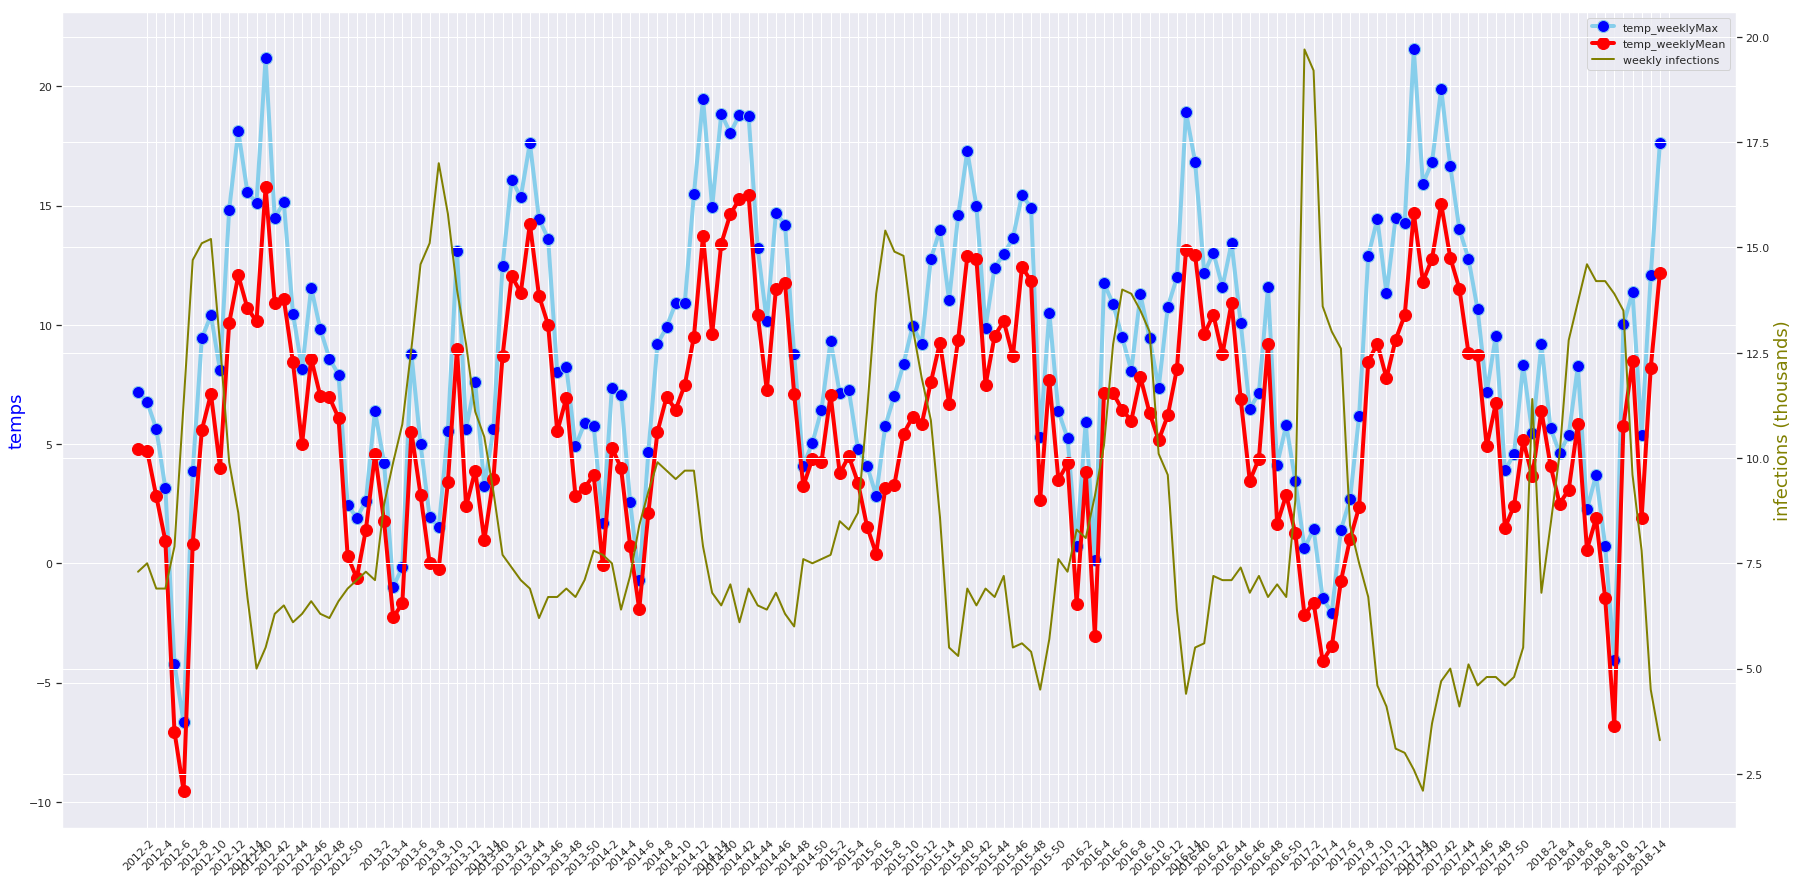

In [95]:
fig, ax1 = plt.subplots(figsize=(30,15))
xaxis = data_merged.index.values
xaxis = list(range(len(xaxis)))
xaxisvalues = []
for year, week in data_merged.index.values:
    if week % 2 == 0:
        xaxisvalues.append(str(year) + "-" + str(week))
    else:
        xaxisvalues.append('')

infections = data_merged['weekly_infections'].values.astype(int)
infections_sorted = np.sort(infections)
line1 = ax1.plot(xaxis, 'temp_weeklyMax', data=data_merged, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
line2 = ax1.plot(xaxis, 'temp_weeklyMean', data=data_merged, marker='o', markerfacecolor='red', markersize=12, color="red", linewidth=4)
ax1.set_ylabel("temps", fontsize=18, color="blue")
ax1.set_xticks(np.arange(1, len(xaxis) + 1 , 1))
ax1.set_xticklabels(xaxisvalues, rotation = 45, ha="right")

ax2 = ax1.twinx()
line3 = ax2.plot(xaxis, infections/1000, marker='', color='olive', linewidth=2, linestyle='solid', label="weekly infections")
ax2.set_ylabel("infections (thousands)", fontsize=18, color="olive")

lns = line1+line2+line3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
plt.show()

plot_lines = [[line1,line2,line3]]
fig.savefig(studentID+'_03.png', bbox_inches='tight')

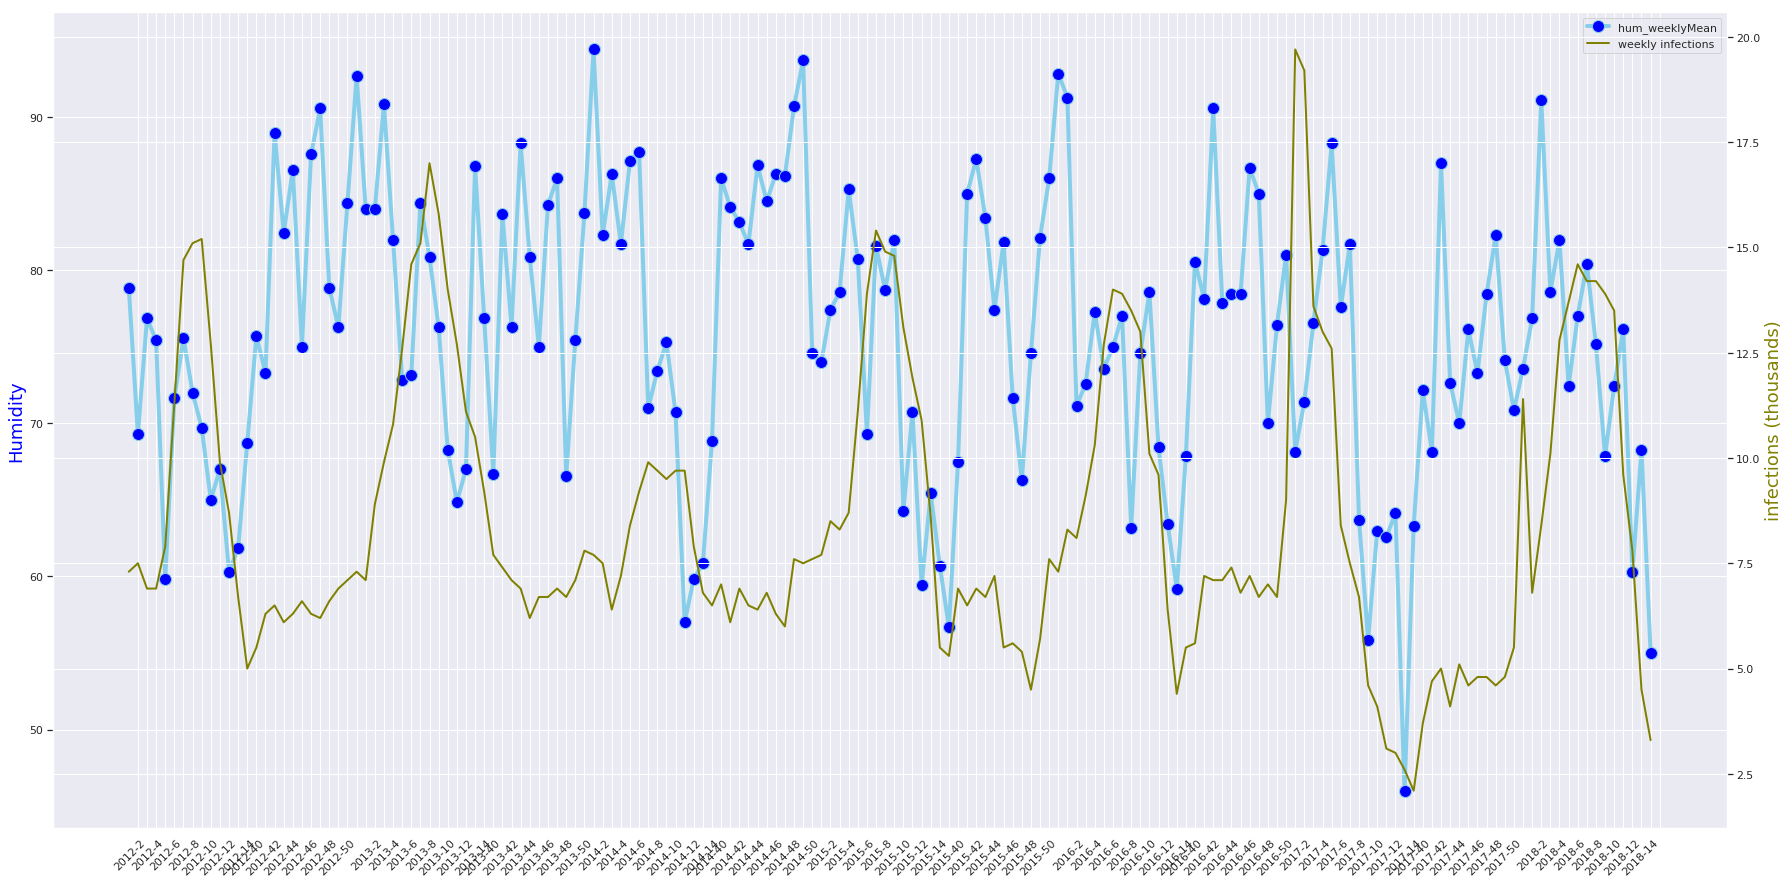

In [96]:
fig, ax1 = plt.subplots(figsize=(30,15))
xaxis = data_merged.index.values
xaxis = list(range(len(xaxis)))
xaxisvalues = []
for year, week in data_merged.index.values:
    if week % 2 == 0:
        xaxisvalues.append(str(year) + "-" + str(week))
    else:
        xaxisvalues.append('')

infections = data_merged['weekly_infections'].values.astype(int)
infections_sorted = np.sort(infections)
line1 = ax1.plot(xaxis, data_merged['hum_weeklyMean'], marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
ax1.set_ylabel("Humidity", fontsize=18, color="blue")
ax1.set_xticks(np.arange(1, len(xaxis) + 1 , 1))
ax1.set_xticklabels(xaxisvalues, rotation = 45, ha="right")

ax2 = ax1.twinx()
line2 = ax2.plot(xaxis, infections/1000, marker='', color='olive', linewidth=2, linestyle='solid', label="weekly infections")
ax2.set_ylabel("infections (thousands)", fontsize=18, color="olive")

lns = line1+line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
plt.show()

plot_lines = [[line1,line2]]
fig.savefig(studentID+'_04.png', bbox_inches='tight')

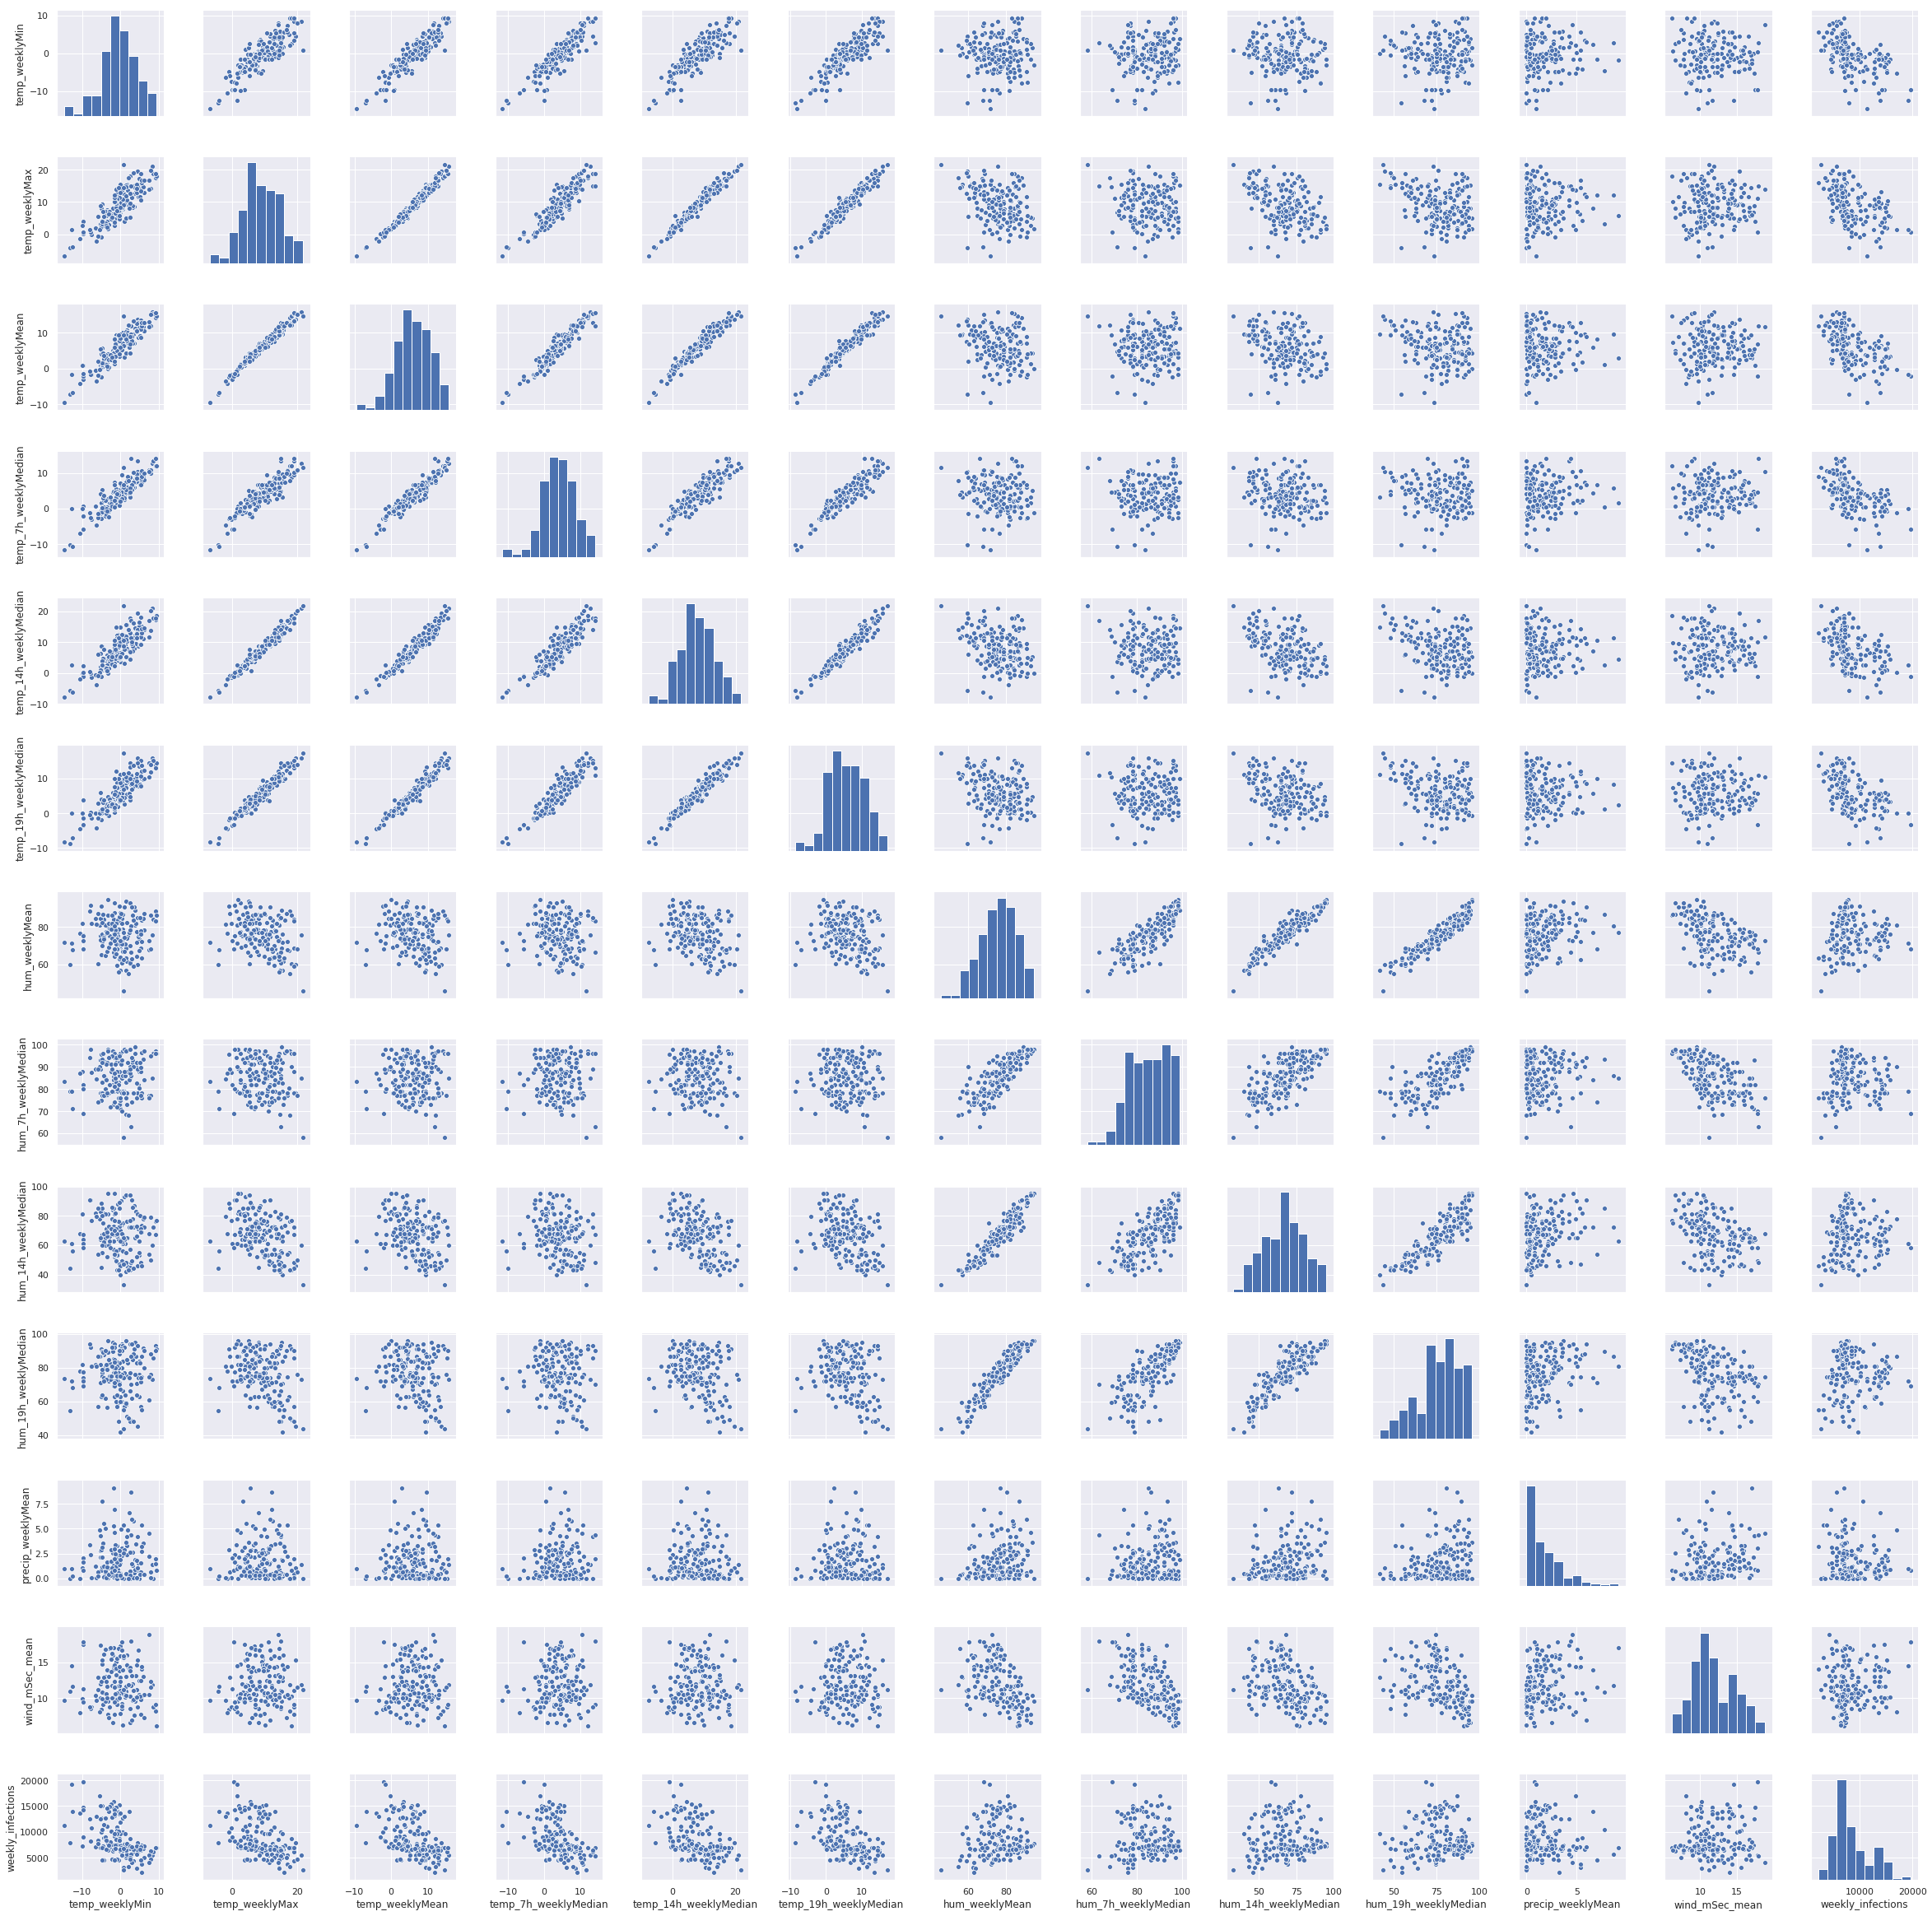

In [97]:
data_merged['weekly_infections'] = pd.to_numeric(data_merged['weekly_infections'])
sns.set(font_scale=1)  # crazy big
f = sns.pairplot(data_merged)
f.savefig(studentID+'_05.png', bbox_inches='tight')

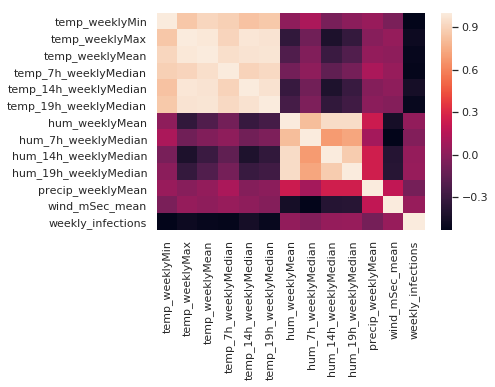

In [99]:
plot = sns.heatmap(data_merged.corr())
f = plot.get_figure()
f.savefig(studentID+'_06.png', bbox_inches='tight')

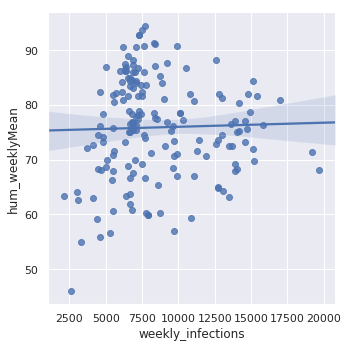

In [100]:
f = sns.lmplot(x="weekly_infections",y="hum_weeklyMean", data=data_merged)
f.savefig(studentID+'_07.png', bbox_inches='tight')

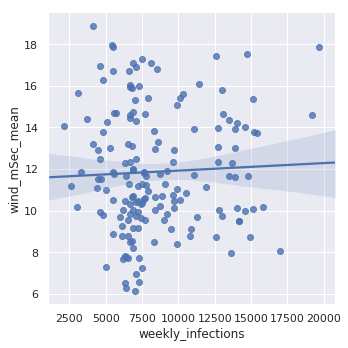

In [101]:
f = sns.lmplot(x="weekly_infections",y="wind_mSec_mean", data=data_merged)
f.savefig(studentID+'_08.png', bbox_inches='tight')

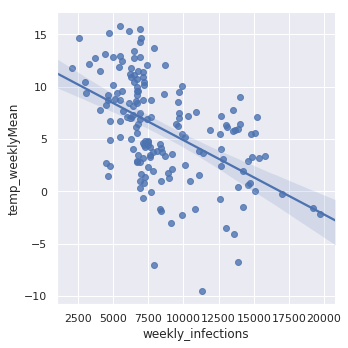

In [102]:
f = sns.lmplot(x='weekly_infections', y="temp_weeklyMean", data=data_merged)
f.savefig(studentID+'_09.png', bbox_inches='tight')

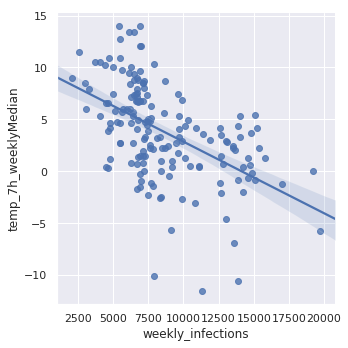

In [103]:
f = sns.lmplot(x='weekly_infections', y='temp_7h_weeklyMedian', data=data_merged)
f.savefig(studentID+'_10.png', bbox_inches='tight')

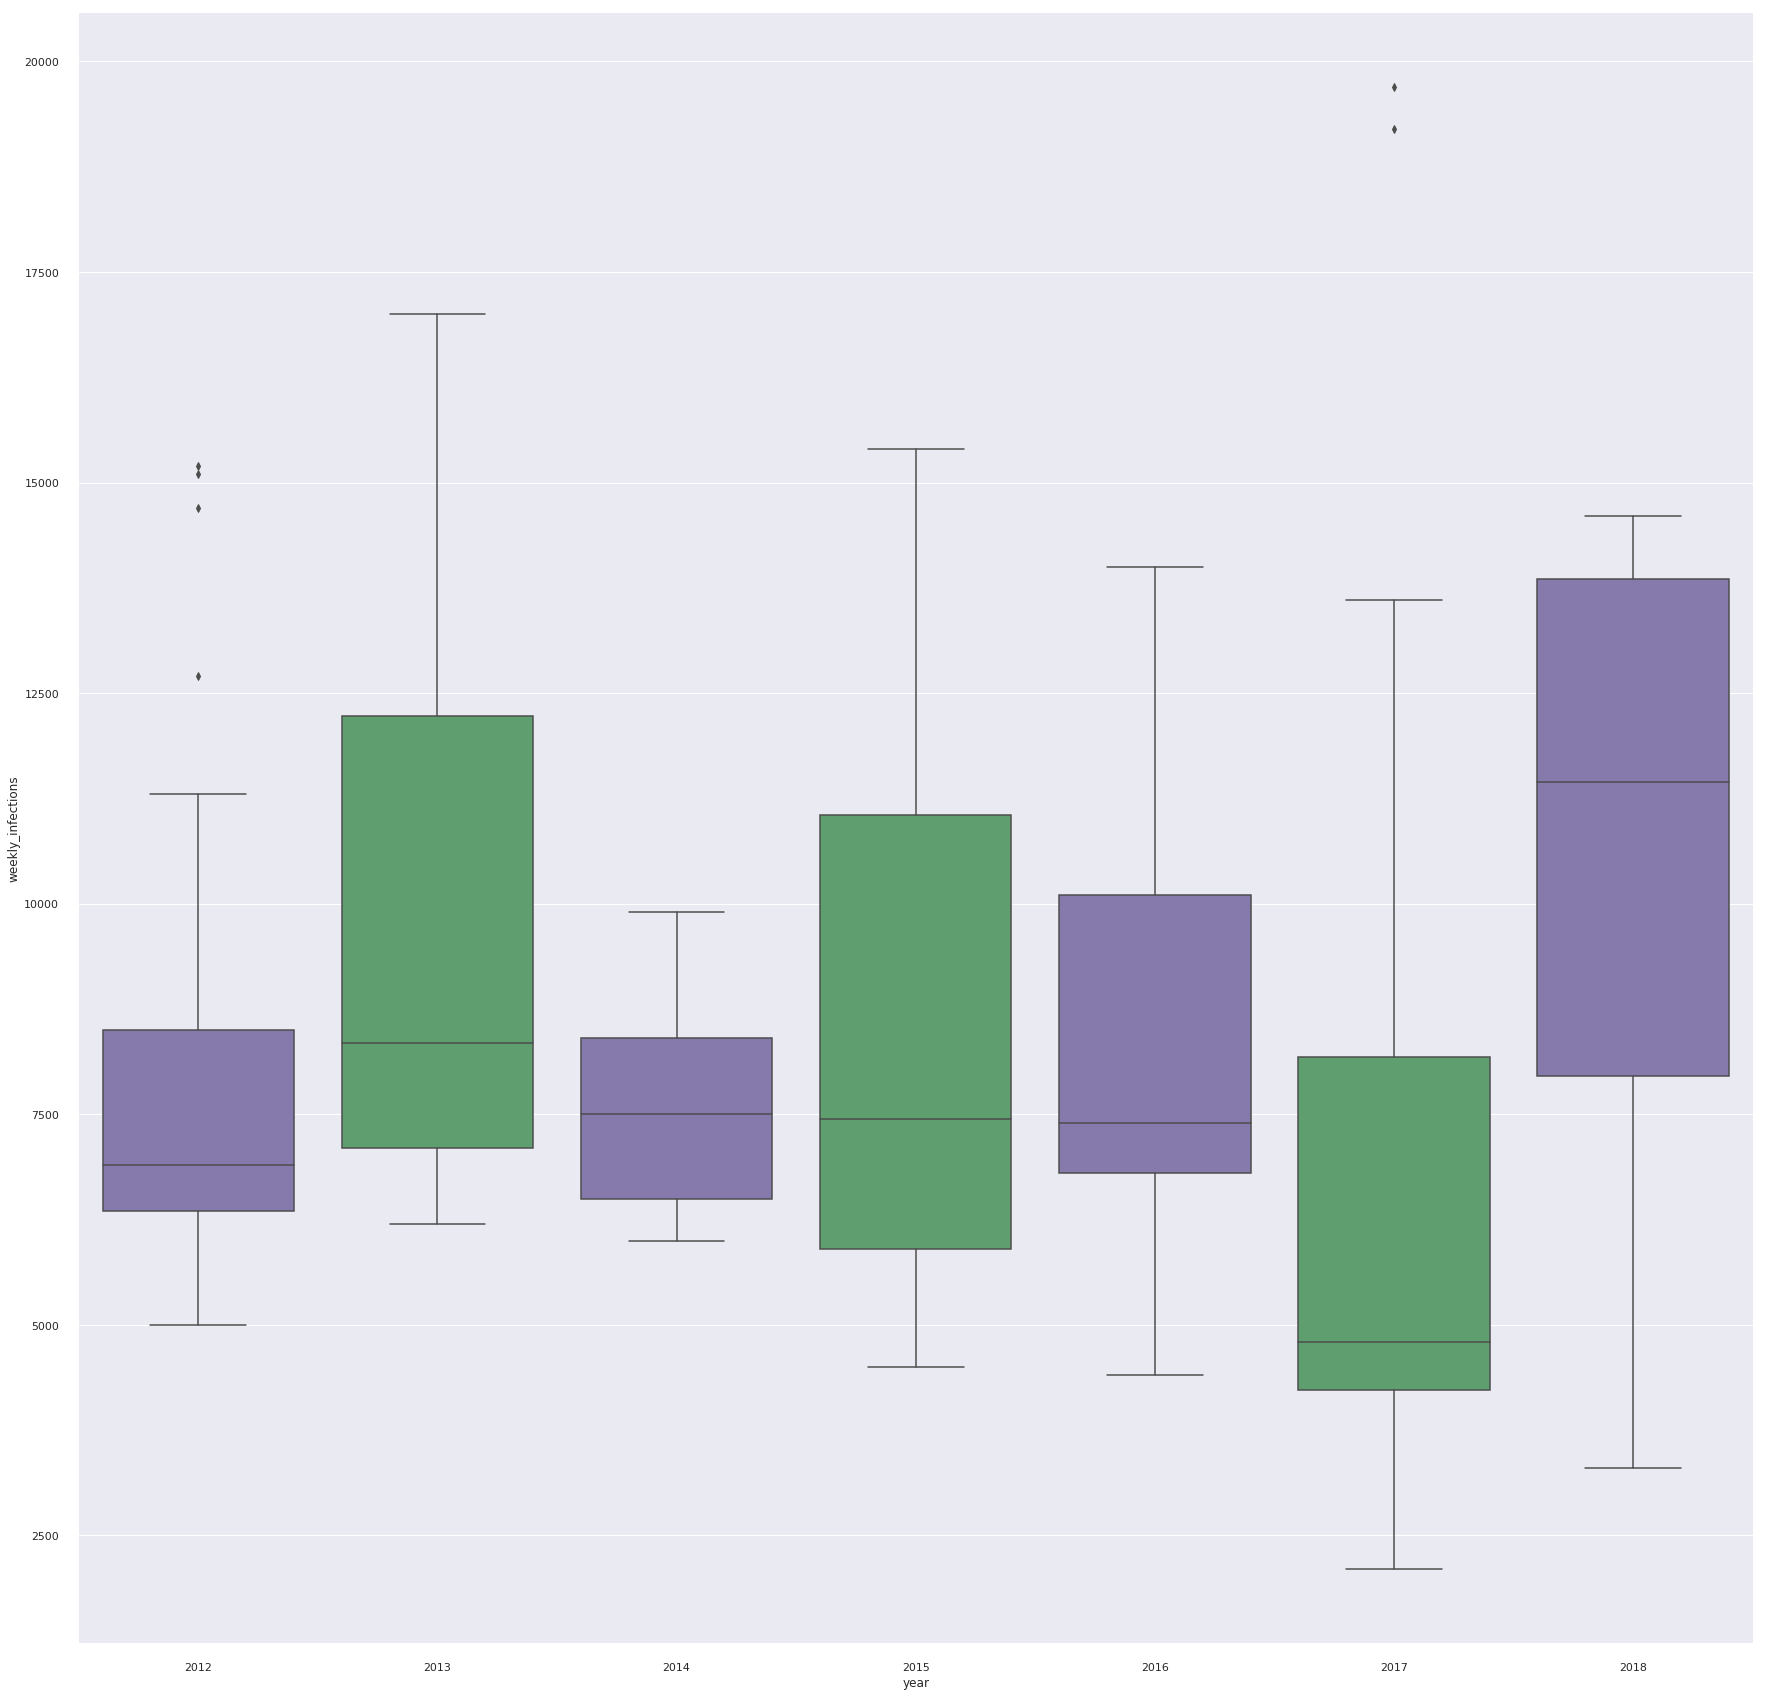

In [104]:
fig, ax = plt.subplots(figsize=(30,30))
sns.boxplot(x='year', y='weekly_infections', data=data_merged.reset_index(), palette=["m", "g"])
sns.despine(offset=10, trim=True)
fig.savefig(studentID+'_11.png', bbox_inches='tight')

## Task 7: Influenza prediction model  <span style="color:blue">(11 P)</span>

Build a model to predict the number of influenza incidents for the year 2018 (discarding all the data available for 2018) based on data of previous year using `sklearn`. 

 - Choose appropriate machine learning algorithm(s) for the problem at hand
 - Make sure your results are reproducible
 - Don't hesitate to go back to previous steps if you notice any data quality issues
 - If your chosen algorithm has specific parameters, explore their effect with different settings using 10-fold cross-validation
 - Experiment with different training/test splits
 - If appropriate, try different scaling approaches (min/max, z-score,..).
 - How good does your model fit when you evaluate it with the test data set?
 - How good are your predictions when you use the actual data available for 2018 as a validation set?


In [34]:
# 2018 data as actual data
data_with_2018 = data_merged.loc[2018]
data_without_2018 = data_merged.drop(index=2018)

In [35]:

scoredf = pd.DataFrame(columns=['Algorithm', 'Parameters', '10-cv mean', '10-cv std', 'R2-score', 'MSE', 'MAE', 'RMAE'])
X = data_without_2018.loc[:, data_without_2018.columns != 'weekly_infections']
y = pd.to_numeric(data_without_2018['weekly_infections'])


In [36]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [37]:
print("\n")
print("LINEAR REGRESSION FIT")
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [38]:
# print the intercept
print("\n")
print("LINEAR REGRESSION INTERCEPT")
print(lm.intercept_)

1914.490576115858


In [39]:
print("\n")
print("COEFFICIENTS FOR LINBEAR REGRESSION")
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
temp_weeklyMin,-542.253230
temp_weeklyMax,-668.800462
temp_weeklyMean,840.743231
temp_7h_weeklyMedian,-109.137826
temp_14h_weeklyMedian,779.646419
temp_19h_weeklyMedian,-677.437728
hum_weeklyMean,-139.606792
hum_7h_weeklyMedian,150.200104
hum_14h_weeklyMedian,20.020996
hum_19h_weeklyMedian,16.313430


# Intepreting coefficients

Holding all units fixed:
* 1 unit increase in temp_weeklyMin is associated with an *decrease of ~542 weekly infections*
* 1 unit increase in temp_weeklyMax is associated with an *decrease of ~668 weekly infections*
* 1 unit increase in temp_weeklyMean is associated with an *increase of ~840 weekly infections*
* 1 unit increase in temp_7h_weeklyMedian is associated with an *decrease of ~109 weekly infections*
* 1 unit increase in temp_14h weeklyMedian is associated with an *increase of ~779 weekly infections*
* 1 unit increase in temp_19h_weeklyMedia is associated with an *decrease of ~677 weekly infections*
* 1 unit increase in hum_weeklyMean is associated with an *decrease of ~139 weekly infections*
* 1 unit increase in hum_7h_weeklyMedian is associated with an *increase of ~150 weekly infections*
* 1 unit increase in hum_14h_weeklyMedian is associated with an *increase of ~20 weekly infections*
* 1 unit increase in hum_19h_weeklyMedian is associated with an *increase of ~16 weekly infections*
* 1 unit increase in precip_weeklyMean is associated with an *decrease of ~148 weekly infections*
* 1 unit increase in wind_mSec_mean is associated with an *increase of ~59 weekly infections*

So in a nutshell if:
* Average temperature increases: weekly infections increases
* if average humidity increases: weekly infections decreases
* if wind increases: weekly infections increases
* if there's more rain: weekly infections decreases

In my opinion these doesn't make so much sense so let's investigate further

In [40]:
predictions = lm.predict(X_test)

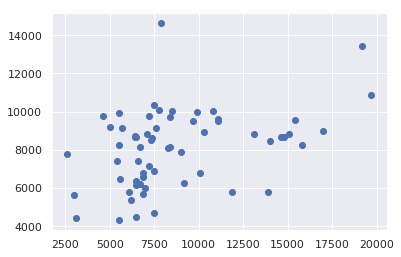

In [41]:
plt.scatter(y_test,predictions)

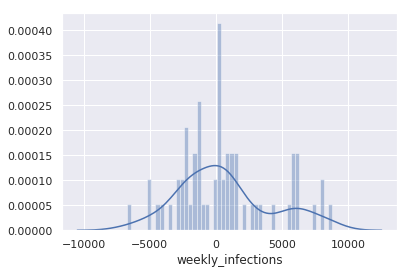

In [42]:
sns.distplot((y_test-predictions),bins=50);

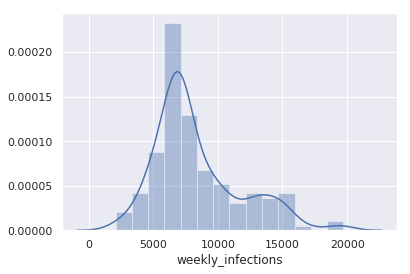

In [43]:
sns.distplot(data_without_2018['weekly_infections'].astype(int))

In [44]:
MAE = metrics.mean_absolute_error(y_test, predictions)
MSE = metrics.mean_squared_error(y_test, predictions)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, predictions))
R2Score = metrics.r2_score(y_test, predictions)

print("\n")
print("SCORES FOR FIRST PREDICTION WITH DEFAULT VALUES: ")
print("\n")
print('MAE:', MAE)
print('MSE:', MSE)
print('RMSE:', RMSE)
print('R2 score: ', R2Score)

MAE: 2694.9879785574108
MSE: 12831730.17649946
RMSE: 3582.140446227571
R2 score:  0.11022508298889888


In [45]:
from sklearn.model_selection import cross_val_score, cross_val_predict
scores = cross_val_score(lm, X_train, y_train, cv = 10, scoring='r2')    #cv is the number of folds, scores will give an array of scores
print (scores)
print (np.mean(scores))
print(np.std(scores))

[-0.01927691  0.11579965  0.27114078  0.72583865  0.51135698  0.12708738
  0.13349286 -0.60457316  0.32199386  0.07091037]
0.1653770467075419
0.333214509530583


In [47]:
print("\n")
print("SCORES DATAFRAME SO FAR: ")
print("\n")

scoredf.loc[-1] = ['LinearRegression', lm.get_params(), np.mean(scores), np.std(scores), R2Score, MSE, MAE, RMSE]
scoredf.index = scoredf.index+1
scoredf

,Algorithm,Parameters,10-cv mean,10-cv std,R2-score,MSE,MAE,RMAE
0,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.165377,0.333215,0.110225,1.283173e+07,2694.987979,3582.140446


# Try to get better results with gridsearch

In [48]:

parameters = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False],
    'n_jobs': [1, 2, 4, 8, 16, 32, 100]
}

In [49]:
clf = GridSearchCV(lm,parameters, cv=10) 
clf.fit(X_train, y_train)

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_copy_X',
 'param_fit_intercept',
 'param_n_jobs',
 'param_normalize',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'split5_test_score',
 'split5_train_score',
 'split6_test_score',
 'split6_train_score',
 'split7_test_score',
 'split7_train_score',
 'split8_test_score',
 'split8_train_score',
 'split9_test_score',
 'split9_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [50]:
print("\n")
print("BEST PARAMETERS FOR LINEAR REGRESSION: ")
print("\n")
gridsearchresult = pd.DataFrame.from_dict(clf.cv_results_)
gridsearchresult.sort_values('rank_test_score')['params'][0]

{'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'normalize': True}

In [51]:
lm2 = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)
lm2.fit(X_train, y_train)
predictions2 = lm2.predict(X_test)

print("\n")
print("LINEAR REGRESSION SCORES WITH BEST PARAMETERS FROM GRIDSEARCH: ")
print("\n")

MAE = metrics.mean_absolute_error(y_test, predictions2)
MSE = metrics.mean_squared_error(y_test, predictions2)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, predictions2))
R2Score = metrics.r2_score(y_test, predictions2)
print('MAE:', MAE)
print('MSE:', MSE)
print('RMSE:', RMSE)
print('R2 score: ', R2Score)
scores = cross_val_score(lm2, X_train, y_train, cv = 10, scoring='r2')    #cv is the number of folds, scores will give an array of scores

print("\n")
print("10-FOLD CROSS VALIDATION MEAN AND STANDARD DEVIATION")
print (np.mean(scores))
print(np.std(scores))
scoredf.drop([0], inplace=True)
scoredf.loc[-1] = ['LinearRegression', lm2.get_params(), np.mean(scores), np.std(scores), R2Score, MSE, MAE, RMSE]
scoredf.index = scoredf.index+1
scoredf

MAE: 2694.9879785574117
MSE: 12831730.176499447
RMSE: 3582.140446227569
R2 score:  0.11022508298889966
[-0.01927691  0.11579965  0.27114078  0.72583865  0.51135698  0.12708738
  0.13349286 -0.60457316  0.32199386  0.07091037]
0.16537704670754172
0.33321450953058507


,Algorithm,Parameters,10-cv mean,10-cv std,R2-score,MSE,MAE,RMAE
0,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.165377,0.333215,0.110225,1.283173e+07,2694.987979,3582.140446


# Decision tree regression

MAE: 2043.3719758064517
MSE: 7975072.011326098
RMSE: 2824.0169991213047
R2 score:  0.44699436947083215
MAE2: 2043.3719758064517
MSE2: 7975072.011326098
RMSE2: 2824.0169991213047
R2 score2:  0.44699436947083215
0.10387398364102704
0.247960587618799
-0.4548088404091642
0.9670197685153303


,Algorithm,Parameters,10-cv mean,10-cv std,R2-score,MSE,MAE,RMAE
2,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.165377,0.333215,0.110225,1.283173e+07,2694.987979,3582.140446
1,DecisionTreeRegressor,"{'criterion': 'mse', 'max_depth': 2, 'max_feat...",0.103874,0.247961,0.446994,7.975072e+06,2043.371976,2824.016999
0,DecisionTreeRegressor,"{'criterion': 'mse', 'max_depth': 5, 'max_feat...",-0.454809,0.967020,0.784686,3.105119e+06,1099.391007,1762.134652


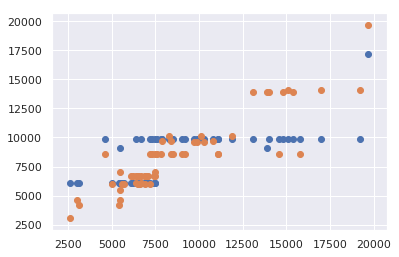

In [52]:
X = data_without_2018.loc[:, data_merged.columns != 'weekly_infections']
y = data_without_2018['weekly_infections'].astype(float)
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

# Predict

y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

plt.scatter(y_test,y_1)
plt.scatter(y_test,y_2)

MAE = metrics.mean_absolute_error(y_test, y_1)
MSE = metrics.mean_squared_error(y_test, y_1)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_1))
R2Score = metrics.r2_score(y_test, y_1)

print("\n")
print("SCORES FOR FIRST DECISION TREE REGRESSOR WITH MAX_DEPTH=2:")

print('MAE:', MAE)
print('MSE:', MSE)
print('RMSE:', RMSE)
print('R2 score: ', R2Score)

MAE2 = metrics.mean_absolute_error(y_test, y_2)
MSE2 = metrics.mean_squared_error(y_test, y_2)
RMSE2 = np.sqrt(metrics.mean_squared_error(y_test, y_2))
R2Score2 = metrics.r2_score(y_test, y_2)

print("\n")
print("SCORES FOR SECOND DECISION TREE REGRESSOR WITH MAX_DEPTH=5:")

print('MAE2:', MAE)
print('MSE2:', MSE)
print('RMSE2:', RMSE)
print('R2 score2: ', R2Score)

scores = cross_val_score(regr_1, X_train, y_train, cv = 10, scoring='r2')    #cv is the number of folds, scores will give an array of scores

print("\n")
print("10-FOLD CROSS VALIDATION MEAN AND STANDAR DEVIATION FOR FIRST DECISION TREE:")


print(np.mean(scores))
print(np.std(scores))
scores1 = cross_val_score(regr_2, X_train, y_train, cv = 10, scoring='r2')

print("\n")
print("10-FOLD CROSS VALIDATION MEAN AND STANDAR DEVIATION FOR SECOND DECISION TREE:")

print(np.mean(scores1))
print(np.std(scores1))
scoredf.loc[-1] = ['DecisionTreeRegressor', regr_1.get_params(), np.mean(scores), np.std(scores), R2Score, MSE, MAE, RMSE]
scoredf.index = scoredf.index+1
scoredf.loc[-1] = ['DecisionTreeRegressor', regr_2.get_params(), np.mean(scores1), np.std(scores1), R2Score2, MSE2, MAE2, RMSE2]
scoredf.index = scoredf.index+1

print("\n")
print("SCORES DATAFRAME SO FAR")
scoredf

In [54]:

parameters = {
    'criterion': ['mse', 'friedman_mse', 'mae'],
    'splitter': ['best', 'random'],
    'max_depth': [2,5,10],
    'min_samples_split': [10, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'random_state': [123],
    'presort': [True, False]
}
regr = DecisionTreeRegressor()
clf = GridSearchCV(regr,parameters, cv=10) 
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['mse', 'friedman_mse', 'mae'], 'splitter': ['best', 'random'], 'max_depth': [2, 5, 10], 'min_samples_split': [10, 50, 100], 'max_features': ['auto', 'sqrt', 'log2', None], 'random_state': [123], 'presort': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [55]:
gridsearchresult = pd.DataFrame.from_dict(clf.cv_results_)
best_params = gridsearchresult.sort_values('rank_test_score')['params'][0]
best_mean_test_score = gridsearchresult.sort_values('rank_test_score')['mean_train_score'][0]

print("\n")
print("BEST PARAMETERS FOR DECISION TREE WITH GRID SEARCH")

print(best_params)
print(best_mean_test_score)

{'criterion': 'mse', 'max_depth': 2, 'max_features': 'auto', 'min_samples_split': 10, 'presort': True, 'random_state': 123, 'splitter': 'best'}
0.38887291510092664


MAE: 2043.3719758064517
MSE: 7975072.011326098
RMSE: 2824.0169991213047
R2 score:  0.44699436947083215


,Algorithm,Parameters,10-cv mean,10-cv std,R2-score,MSE,MAE,RMAE
3,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.165377,0.333215,0.110225,1.283173e+07,2694.987979,3582.140446
2,DecisionTreeRegressor,"{'criterion': 'mse', 'max_depth': 2, 'max_feat...",0.103874,0.247961,0.446994,7.975072e+06,2043.371976,2824.016999
1,DecisionTreeRegressor,"{'criterion': 'mse', 'max_depth': 5, 'max_feat...",-0.454809,0.967020,0.784686,3.105119e+06,1099.391007,1762.134652
0,DecisionTreeRegressor,"{'criterion': 'mse', 'max_depth': 2, 'max_feat...",0.103874,0.247961,0.446994,7.975072e+06,2043.371976,2824.016999


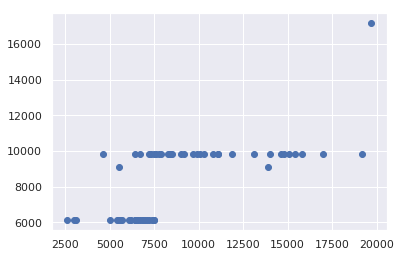

In [56]:
regr_3 = DecisionTreeRegressor(criterion='mse', max_depth=2, 
                               max_features='auto', min_samples_split=10,
                              presort=True, random_state=123,
                              splitter='best')
regr_3.fit(X,y)
predictions3 = regr_3.predict(X_test)
plt.scatter(y_test, predictions3)

MAE = metrics.mean_absolute_error(y_test, predictions3)
MSE = metrics.mean_squared_error(y_test, predictions3)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, predictions3))
R2Score = metrics.r2_score(y_test, predictions3)

print("\n")
print("SCORES FOR DECISION TREE REGRESSOR WITH BEST PARAMETERS")

print('MAE:', MAE)
print('MSE:', MSE)
print('RMSE:', RMSE)
print('R2 score: ', R2Score)

print("\n")
print("SCORES DATAFRAME SO FAR")
scores2 = cross_val_score(regr_3, X_train, y_train, cv = 10)
scoredf.loc[-1] = ['DecisionTreeRegressor', regr_3.get_params(), np.mean(scores2), np.std(scores2), R2Score, MSE, MAE, RMSE]
scoredf.index = scoredf.index+1
scoredf

In [57]:
# comparing results
# from previous test it seems that linear regression has the best cross validation score
print("\n")
print("LINEAR REGRESSION IS THE BEST ALGORITHM SO FAR, RUNNING IT AND COMPARING IT TO REAL 2018 VALUES: ")

lm3 = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)
lm3.fit(X_train, y_train)
real_X = data_with_2018.loc[:, data_with_2018.columns != 'weekly_infections']
real_Y = data_with_2018['weekly_infections']
predictions = lm3.predict(real_X)

In [60]:
# comparing predicted values with real values
reviewdf = pd.DataFrame(columns=['predicted', 'real'])
reviewdf['predicted'] = predictions
reviewdf['real'] = data_with_2018.reset_index()['weekly_infections']
reviewdf['diff'] = reviewdf['predicted'].astype(int) - reviewdf['real'].astype(int)
reviewdf['week'] = reviewdf.index.values
reviewdf

,predicted,real,diff,week
0,6331.269112,6800,-469,0
1,7938.981505,8400,-462,1
2,9524.660048,10100,-576,2
3,9716.689965,12800,-3084,3
4,7195.460407,13700,-6505,4
5,6995.944267,14600,-7605,5
6,6860.361181,14200,-7340,6
7,11263.771173,14200,-2937,7
8,10940.101206,13900,-2960,8
9,10904.738615,13500,-2596,9


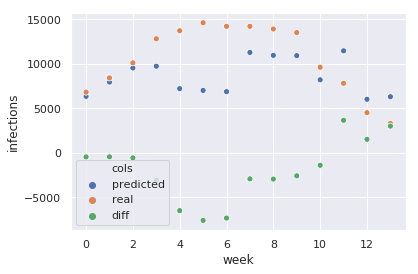

In [61]:
df = reviewdf.melt('week', var_name='cols',  value_name='infections')
g = sns.scatterplot(x='week', y="infections", hue='cols', data=df, legend='full')

In [62]:
print("\n")
print("SCORES FOR LINEAR REGRESSION WITH DEFAULT VALUES PREDICTED WITH DATA OF 2018 X-matrix")

print('MAE:', metrics.mean_absolute_error(reviewdf['real'], reviewdf['predicted']))
print('MSE:', metrics.mean_squared_error(reviewdf['real'], reviewdf['predicted']))
print('RMSE:', np.sqrt(metrics.mean_squared_error(reviewdf['real'], reviewdf['predicted'])))
print('R2 score: ', metrics.r2_score(reviewdf['real'], reviewdf['predicted']))

MAE: 3148.4553019002537
MSE: 15347996.166899722
RMSE: 3917.6518690281455
R2 score:  -0.10491862390997642


# SVR

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101) # notice test split is now 0.33
clf = SVR(gamma=0.001, C=1.0, epsilon=0.2)
clf.fit(X, y)
    
predictions4 = clf.predict(X_test)
MAE = metrics.mean_absolute_error(y_test, predictions4)
MSE = metrics.mean_squared_error(y_test, predictions4)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, predictions4))
R2Score = metrics.r2_score(y_test, predictions4)

print("\n")
print("SCORES FOR SVR (GAMMA=0.001, C=1.0, EPSILON=0.2)")
print('MAE:', MAE)
print('MSE:', MSE)
print('RMSE:', RMSE)
print('R2 score: ', R2Score)

scores = cross_val_score(clf, X_train, y_train, cv = 10, scoring='r2')    #cv is the number of folds, scores will give an array of scores
print("\n")
print("10-fold cross validation mean and standard deviation: ")
print(np.mean(scores))
print(np.std(scores))
scoredf.loc[-1] = ['SVR', clf.get_params(), np.mean(scores), np.std(scores), R2Score, MSE, MAE, RMSE]
scoredf.index = scoredf.index+1

print("\n")
print("SCORES DATA FRAME SO FAR:")

scoredf


MAE: 2295.040317954758
MSE: 12711943.054067168
RMSE: 3565.3811933743027
R2 score:  -0.09552093226066805
[-0.65192393 -0.02875296 -0.09396867 -0.22869741 -0.79959538 -0.08907138
 -0.14412491 -0.08309405 -0.20617291 -0.29090387]
-0.2616305471796133
0.24587683048859477


,Algorithm,Parameters,10-cv mean,10-cv std,R2-score,MSE,MAE,RMAE
4,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.165377,0.333215,0.110225,1.283173e+07,2694.987979,3582.140446
3,DecisionTreeRegressor,"{'criterion': 'mse', 'max_depth': 2, 'max_feat...",0.103874,0.247961,0.446994,7.975072e+06,2043.371976,2824.016999
2,DecisionTreeRegressor,"{'criterion': 'mse', 'max_depth': 5, 'max_feat...",-0.454809,0.967020,0.784686,3.105119e+06,1099.391007,1762.134652
1,DecisionTreeRegressor,"{'criterion': 'mse', 'max_depth': 2, 'max_feat...",0.103874,0.247961,0.446994,7.975072e+06,2043.371976,2824.016999
0,SVR,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...",-0.261631,0.245877,-0.095521,1.271194e+07,2295.040318,3565.381193


In [64]:
# improve with gridsearch
svr = SVR()
parameters = {
    'kernel': ['rbf','sigmoid', 'linear'],
    'gamma': [2**-15, 2**-13, 2**3],
    'C': [2**-5, 2**-3, 2**15],
    'shrinking': [True, False]
}
clf = GridSearchCV(svr,parameters, cv=10) 
clf.fit(X_train, y_train)


GridSearchCV(cv=10, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf', 'sigmoid', 'linear'], 'gamma': [3.0517578125e-05, 0.0001220703125, 8], 'C': [0.03125, 0.125, 32768], 'shrinking': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [65]:
gridsearchresult = pd.DataFrame.from_dict(clf.cv_results_)
best_params = gridsearchresult.sort_values('rank_test_score')['params'][0]
best_mean_test_score = gridsearchresult.sort_values('rank_test_score',ascending=True)['mean_train_score'][0]

print("\n")
print("BEST PARAMETERS FOUND WITH GRID SEARCH FOR SVR (AND BEST MEAN TEST SCORE):")
print(best_params)
print(best_mean_test_score)




{'C': 0.03125, 'gamma': 3.0517578125e-05, 'kernel': 'rbf', 'shrinking': True}
-0.12932140202511472


In [66]:
# Lets try polnymoial svr but less dimension
# Try removing precip and wind
df = data_without_2018.drop(['precip_weeklyMean', 'wind_mSec_mean'], axis=1)
X = df.loc[:, df.columns != 'weekly_infections']
y = df['weekly_infections'].astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

#data_without_2018.info()
svr2 = SVR(C=0.03125, gamma=3.05e-05, kernel='poly', shrinking=True)
svr2.fit(X_train, y_train)
predictions5 = svr2.predict(X_test)
MAE = metrics.mean_absolute_error(y_test, predictions5)
MSE = metrics.mean_squared_error(y_test, predictions5)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, predictions5))
R2Score = metrics.r2_score(y_test, predictions5)

print("\n")
print("SCORES FOR SVR WITH OPTIMAL SCORES FOUND WITH GRIDSEARCH")
print('MAE:', MAE)
print('MSE:', MSE)
print('RMSE:', RMSE)
print('R2 score: ', R2Score)
scores = cross_val_score(svr2, X_train, y_train, cv = 10, scoring='r2')    #cv is the number of folds, scores will give an array of scores


print("\n")
print("10-FOLD CROSS VALIDATION AVERAGE AND STANDARD DEVIATION:")
print (np.mean(scores))
print(np.std(scores))
scoredf.loc[-1] = ['SVR', svr2.get_params(), np.mean(scores), np.std(scores), R2Score, MSE, MAE, RMSE]
scoredf.index = scoredf.index+1
scoredf

print("\n")
print("SVR POLY WITH HIGH C AND SCORES")
svr3 = SVR(C=5, gamma=0.0001, kernel='poly', shrinking=True)
svr3.fit(X_train, y_train)
predictions6 = svr3.predict(X_test)
MAE1 = metrics.mean_absolute_error(y_test, predictions6)
MSE1 = metrics.mean_squared_error(y_test, predictions6)
RMSE1 = np.sqrt(metrics.mean_squared_error(y_test, predictions6))
R2Score1 = metrics.r2_score(y_test, predictions6)
print('MAE:', MAE1)
print('MSE:', MSE1)
print('RMSE:', RMSE1)
print('R2 score: ', R2Score1)

print("\n")
print("10-FOLD CROSS VALIDATION AVERAGE AND STANDARD DEVIATION:")
scores1 = cross_val_score(svr3, X_train, y_train, cv = 10, scoring='r2')    #cv is the number of folds, scores will give an array of scores
print (np.mean(scores1))
print(np.std(scores1))
scoredf.loc[-1] = ['SVR', svr3.get_params(), np.mean(scores1), np.std(scores1), R2Score1, MSE1, MAE1, RMSE1]
scoredf.index = scoredf.index+1

print("\n")
print("SCORES DATA FRAME SO FAR:")
scoredf


MAE: 2300.003588374714
MSE: 12754110.052825889
RMSE: 3571.2896904095987
R2 score:  -0.09915490305445696
[-0.65347497 -0.03015672 -0.09516352 -0.22911996 -0.80109965 -0.09015261
 -0.14583137 -0.08284037 -0.20621544 -0.29300882]
-0.2627063415572738
0.24611810600563133
SVR POLY WITH HIGH C
MAE: 2271.3381741960116
MSE: 12720386.863769956
RMSE: 3566.5651352204345
R2 score:  -0.09624862355365815
[-0.63879356 -0.01756843 -0.10006989 -0.23787033 -0.73220662 -0.07461398
 -0.1266137  -0.09515891 -0.20582091 -0.27722932]
-0.2505945649268583
0.23086449648771942


,Algorithm,Parameters,10-cv mean,10-cv std,R2-score,MSE,MAE,RMAE
6,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.165377,0.333215,0.110225,1.283173e+07,2694.987979,3582.140446
5,DecisionTreeRegressor,"{'criterion': 'mse', 'max_depth': 2, 'max_feat...",0.103874,0.247961,0.446994,7.975072e+06,2043.371976,2824.016999
4,DecisionTreeRegressor,"{'criterion': 'mse', 'max_depth': 5, 'max_feat...",-0.454809,0.967020,0.784686,3.105119e+06,1099.391007,1762.134652
3,DecisionTreeRegressor,"{'criterion': 'mse', 'max_depth': 2, 'max_feat...",0.103874,0.247961,0.446994,7.975072e+06,2043.371976,2824.016999
2,SVR,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...",-0.261631,0.245877,-0.095521,1.271194e+07,2295.040318,3565.381193
1,SVR,"{'C': 0.03125, 'cache_size': 200, 'coef0': 0.0...",-0.262706,0.246118,-0.099155,1.275411e+07,2300.003588,3571.289690
0,SVR,"{'C': 5, 'cache_size': 200, 'coef0': 0.0, 'deg...",-0.250595,0.230864,-0.096249,1.272039e+07,2271.338174,3566.565135


# Comparing algorithms with real 2018 values

In [78]:
scoredf.sort_values('R2-score', ascending=False,inplace=True)
print("Best LR parameters: {}".format(scoredf[scoredf['Algorithm'] == 'LinearRegression'].reset_index().loc[0]['Parameters']))
print("\n")
print("Best DT Parameters: {}".format(scoredf[scoredf['Algorithm'] == 'DecisionTreeRegressor'].reset_index().loc[0]['Parameters']))
print("\n")
print("Best SVR Parameters: {}".format(scoredf[scoredf['Algorithm'] == 'SVR'].reset_index().loc[0]['Parameters']))

Best LR parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'normalize': True}


Best DT Parameters: {'criterion': 'mse', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}


Best SVR Parameters: {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [79]:
print("\n")
print("comparing predicted values with real values")
print("\n")
reviewdf = pd.DataFrame(columns=['predicted_lr', 'predicted_dt', 'predicted_svr', 'real'])

X = data_without_2018.loc[:, data_merged.columns != 'weekly_infections']
y = data_without_2018['weekly_infections'].astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

lr = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)
dt_regr = DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None, max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1,
                               min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=None,
                               splitter='best')
svr = SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma=0.001, kernel='rbf', max_iter=-1, shrinking=True,
         tol=0.001, verbose=False)

lr.fit(X_train, y_train)
dt_regr.fit(X_train, y_train)
svr.fit(X_train, y_train)

predicted_lr = lr.predict(real_X)
predicted_dt = dt_regr.predict(real_X)
predicted_svr = svr.predict(real_X)

print("\n")
print("R2 SCORES PREDICTED VALUES VS REAL 2018 VALUES (3 DIFFERENT ALGORITHMS)")
print("R2 lr: {}".format(metrics.r2_score(real_Y, predicted_lr)))
print("R2 dt: {}".format(metrics.r2_score(real_Y, predicted_dt)))
print("R2 svr: {}".format(metrics.r2_score(real_Y, predicted_svr)))


print("\n")
print("COMPARING PREDICTED VALUES WITH REAL VALUES")


reviewdf['predicted_lr'] = predicted_lr
reviewdf['predicted_dt'] = predicted_dt
reviewdf['predicted_svr'] = predicted_svr
reviewdf['real'] = data_with_2018.reset_index()['weekly_infections']
#reviewdf['diff'] = reviewdf['predicted'].astype(int) - reviewdf['real'].astype(int)
reviewdf['week'] = reviewdf.index.values
reviewdf

R2 lr: -0.10491862390997642
R2 dt: -0.20987001842424458
R2 svr: -0.843747736834217


,predicted_lr,predicted_dt,predicted_svr,real,week
0,6331.269112,9362.500000,7102.044456,6800,0
1,7938.981505,7218.750000,7103.365467,8400,1
2,9524.660048,7218.750000,7104.248055,10100,2
3,9716.689965,7218.750000,7103.242427,12800,3
4,7195.460407,12246.666667,7104.018424,13700,4
5,6995.944267,7218.750000,7105.314649,14600,5
6,6860.361181,7218.750000,7103.581566,14200,6
7,11263.771173,13600.000000,7106.907403,14200,7
8,10940.101206,7600.000000,7106.724747,13900,8
9,10904.738615,12246.666667,7105.507014,13500,9


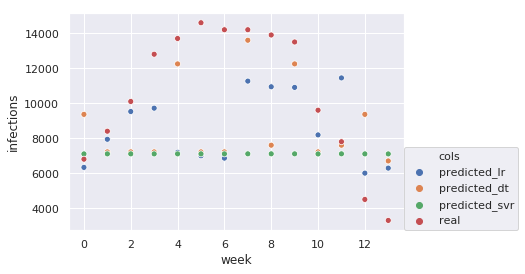

In [80]:
df = reviewdf.melt('week', var_name='cols',  value_name='infections')
#g = sns.scatterplot(x='week', y="infections", hue='cols', data=df)
g = sns.scatterplot(x='week', y="infections", hue='cols', data=df)
g.legend(loc=(1,0))

In [81]:
scaleddf = data_without_2018.copy()
scaleddf[scaleddf.columns] = scale(scaleddf[scaleddf.columns])
X = scaleddf.loc[:, scaleddf.columns != 'weekly_infections']
y = scaleddf['weekly_infections'].astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

lr = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)
lr.fit(X_train, y_train)

predicted_lr = lr.predict(X_test)

# min max

scalerminmax = MinMaxScaler()
dfminmax = data_without_2018.copy()
dfminmax[dfminmax.columns] = scalerminmax.fit_transform(dfminmax[dfminmax.columns])
X = dfminmax.loc[:, dfminmax.columns != 'weekly_infections']
y = dfminmax['weekly_infections'].astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

lr2 = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)
lr2.fit(X_train, y_train)
predicted_lr2 = lr2.predict(X_test)
print(metrics.r2_score(y_test, predicted_lr2))


# normalize

scalernorm = Normalizer()
dfnorm = data_without_2018.copy()
#dfnorm[dfnorm.columns] = scalernorm.transform(dfnorm[dfnorm.columns])
#X = dfnorm.loc[:, dfnorm.columns != 'weekly_infections']
X = dfnorm.loc[:, dfnorm.columns != 'weekly_infections']
X[X.columns] = scalernorm.transform(X[X.columns])
y = dfnorm['weekly_infections'].astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
lr3 = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)
lr3.fit(X_train, y_train)
predicted_lr3 = lr3.predict(X_test)


0.17277129250855316
0.1727712925085524
0.21081870885471765


array([ 9630.2570851 ,  8705.5651159 ,  4086.47340224, 13283.79584547,
        9101.35798321,  9954.74498082,  7713.08043104,  6097.12266389,
        5127.37414828, 10376.64609058,  7927.72505431,  9764.01399714,
        7853.94551662,  9487.35006783,  5462.78418086,  9655.56268292,
       16352.94517455,  5522.15817827,  8231.11081659,  8736.7179149 ,
        5476.88435738,  8563.69561888,  8876.64755907,  8376.41006028,
        8672.56166939,  9427.03819279,  6728.48237522,  9481.79742845,
        7097.62072063,  4769.12229273,  9325.60863557,  8012.44939187,
        8222.49391242,  6067.85507108,  9662.10617066,  6402.93439691,
        9019.54744748,  8253.24836659,  4964.38841288,  6137.13499913,
        7117.79469415,  9747.92984626,  6588.79173279,  7235.16022382,
        8422.82345151,  8861.776899  ,  5191.1024718 ])

In [82]:
# comparing predicted values with real values

print("\n")
print("AFTER TRIED NORMALIZING, MIN/MAXING AND STANDARDIZATION")
scalernorm = Normalizer()
dfnorm = data_without_2018.copy()
#dfnorm[dfnorm.columns] = scalernorm.transform(dfnorm[dfnorm.columns])
#X = dfnorm.loc[:, dfnorm.columns != 'weekly_infections']
X = dfnorm.loc[:, dfnorm.columns != 'weekly_infections']
X[X.columns] = scalernorm.transform(X[X.columns])
y = dfnorm['weekly_infections'].astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
lr3 = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)
lr3.fit(X_train, y_train)

real_X_normalized = Normalizer().fit_transform(real_X[real_X.columns])

predicted_lr3 = lr3.predict(real_X_normalized)

PRINT("R2 SCORE WITH LINEAR REGRESSION AFTER NORMALIZING: ")
print(metrics.r2_score(real_Y, predicted_lr3))

reviewdf = pd.DataFrame(columns=['predicted', 'real'])
reviewdf['predicted'] = predicted_lr3
reviewdf['real'] = data_with_2018.reset_index()['weekly_infections']
reviewdf['diff'] = reviewdf['predicted'].astype(int) - reviewdf['real'].astype(int)
reviewdf['week'] = reviewdf.index.values


0.07507268476758355


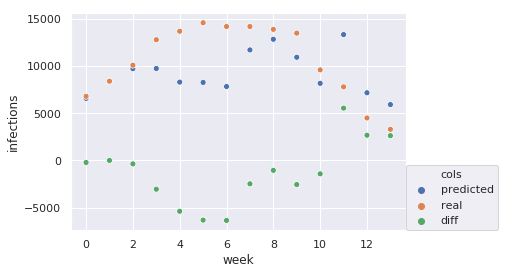

In [106]:
df = reviewdf.melt('week', var_name='cols',  value_name='infections')
#g = sns.scatterplot(x='week', y="infections", hue='cols', data=df)
g = sns.scatterplot(x='week', y="infections", hue='cols', data=df)
g.legend(loc=(1,0))
f = g.get_figure()
f.savefig(studentID+'_12.png', bbox_inches='tight')
print("A FIGURE WITH THE FINAL SCATTER PLOT WITH PREDICTED VALUES AND REAL VALUES IS SAVED.")

#### Approach and algorithm <span style="color:blue">(2 P)</span>
Motivate your approach and choice of algorithm here:

[T7_Model_Description]

I chose 3 regression algorithms to do this exercise. First one I chose was the most simple regression algorithm, which I am already familiar of: Linear Regression. Linear Regression is a good general regression algorithm and without any knowledge of the performance I though that was a good algorithm to start with. 

Second algorithm chosen was DecisionTreeRegressior. The initial idea was that with this decision tree regressor I could more easily get importances for each column and get a better understanding which column affects how much to the end result and if maybe later I could remove some columns to get a more better fit. Also it requires little data preparation. Decision tree didn't turn out to be that much better algorithm than linearregression. I guess the data set is just too small for getting a good prediction

Final algorithm chosen was SVR, Its another algorithm I learned on other courses and I though with that I could fine a good prediction because of the multiple dimensions of this. Also that didn't work out too well. 

For all of the algorithms, several parameter settings were used and for preprocessing was used different imputation techniques and later on, normalizing, min/maxing and standardizing. 

[/T7_Model_Description]

#### Findings  <span style="color:blue">(2 P)</span>
1. Try with linear regression default parameters
result: not so good fit. high error (MSE's) and rsquare of 0.16. I tried applying gridsearchCV with to find better parameters for linear regression. Turned out that the default paremeters were the optimal ones. After not so good result was achieved with linear regression. 

2. Try with decision tree regression.
result: again, results were not as anticipated. all MSE (Mean-squared error) and MAE (Mean Average error) were still quite high. I ran decision tree with two difrferent max-depth settings (2 and 5) but it had no difference in R2 (0.44). 10-fold cross validation (scoring parameter as r2) gave a big std deviation between the folds so I maybe just got a bit lucky getting a good r2 initially.

GridsearchCV was again used to try to better the algorithm. but it turned out that with the best settings the r2 score remained the same.

GridSearchCV was run with the following settings:  

`
parameters = {
    'criterion': ['mse', 'friedman_mse', 'mae'],
    'splitter': ['best', 'random'],
    'max_depth': [2,5,10],
    'min_samples_split': [10, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'random_state': [123],
    'presort': [True, False]
}
`

At this point linearregression still had the better CV-score and lowest standard deviation between the scores. 

3. Try plotting predicted values next to the real values of 2018. 
result. With default values for linear regression I tried to predict some values. Generally there seems to be right trend  with how the values are predicted but there seemst to be a big deviation from the real values for weeks 4-6. R2 square agains the real values was also very weak (-0.10). 

4. Support Vector Regression (SVR)
Support Vector Regression (SVR) with default values did not give any better estimates. The R2 score was -0.09 and the 10-CV mean was very weak (-0.26) which indicates that the results were unconsistent

Running GridSearch on SVR first didn't work so well because the search dimension on polynomial kernel is too high. I only used the rbf, sigmoid and linear kernels for the gridsearch. The best score was found to be with the following settings: 'C': 0.03125, 'gamma': 3.0517578125e-05, 'kernel': 'rbf', 'shrinking': True. 

GridSearchCV Parameters were following:  

`
parameters = {
    'kernel': ['rbf','sigmoid', 'linear'],
    'gamma': [2**-15, 2**-13, 2**3],
    'C': [2**-5, 2**-3, 2**15],
    'shrinking': [True, False]
}
`

After this I tried once more to run SRV with the polynomial kernel without much increase in the 10-cv score.

In the end I found out that the best of these different algorithms was LinearRegression with default values and 10-cv average score of 0.16. All settings of SVR got less than -0.20 average score. A table with these results (as well as the MSE, MAE and RMAE) scores can be found in the notebook.

5. Comparing results with real 2018 scores. 
There is a scatter plot plotting the predicted values using the best found parameters on all three algorithms. From the diagram it is possible to see that the predictions are generally quite far off.

6. After nothing worked I decided to try different scaling options. I tried Normalizing, Serializing and Min/Max scaling. 
result: Against the initial test vector, the best result came with normalizing and I got 0.21 r2 score with linear regression. However, against the real 2018 weather infections the predictions got only 0.075 r2 score, which is better than without normalizing but still quite bad.

Conclusion:
More advanced data preprocessing should probably be done to get better result. Also, it does not help that the data set I ended up toying with had very little samples. So more valid data would help the models a lot. Not a huge correlation was found between any of the features and the weekly infections.



[T7_Model_Findings]

<span style="color:blue">**TODO:**</span> Please remove this text with your answer here, but keep the marker above.

[/T7_Model_Findings]